In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2
import sys
import random
import string
import math
import numpy as np
import fn
import types
import itertools
import json
import copy
import re
import pandas as pd
import torch
import torch.nn as nn
from fn import _
from dataclasses import dataclass
from collections import Counter
from random import sample,choices,choice
from torch.utils.data import Dataset
from itertools import product, chain
from functional import seq
from functional.pipeline import Sequence
from collections import namedtuple 
from collections import defaultdict, OrderedDict
from transformers import AutoModelForCausalLM, LlamaTokenizer
from transformers import Trainer, TrainingArguments, default_data_collator, set_seed, HfArgumentParser

In utils/hub.py: default_cache_path: /home/nrk/.cache/huggingface/hub->/nas/xd/.cache/torch/transformers/


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
# with Timer('utils'): from utils import *
with Timer('child_utils_nrk_2'): from child_utils_nrk_2 import *
from child_utils_nrk_2 import _str, _cxt2str, _item2str, _s, _be
# from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils_nrk_2'): from model_utils_nrk_2 import *
# with Timer('weight_analysis'): from weight_analysis import *

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


common_utils ... done 0:00:00.000016
child_utils_nrk_2 ... In const.py: Loading tokenizer ... done 0:00:00.090484
done 0:00:00.128446
tasks ... done 0:00:00.002491
model_utils_nrk_2 ... done 0:00:00.015541


## 数据部分

In [4]:
# def types_of_things(): return {
#     'animal': ['duck', 'goose', 'dog', 'lion', 'cow', 'donkey', 'horse', 'sheep', 'goat', 'tiger', 'cat', 'pig',
#             'monkey', 'rabbit', 'elephant', 'wolf', 'deer', 'fox', 'gorilla', 'squirrel', 'mouse'], # 'chicken', 'bear', 'zebra', 'giraffe', 'kangaroo', 21-5, 15-8
#     'fruit': ['apple', 'banana', 'pear', 'grapes', 'cherries', 'orange', 'peach', 'plum', 'lemon', 'mango', 'blackberries',
#             'blueberries', 'strawberries', 'durian', 'papaya', 'watermelon', 'pineapple', 'kiwi', 'apricot', 'lime'], # may be food too?
#     # 'vegetable': ['spinach', 'broccoli', 'lettuce', 'cabbage', 'tomato'],
#     'drink': ['tea', 'coffee', 'beer', 'wine', 'whiskey', 'vodka', 'soda', 'juice', 'cocktail'],  # some as alcohol, 21-5, 15-8
#     # 'drink': ['tea', 'coffee', 'beer', 'wine', 'whiskey', 'soda', 'juice',    'vodka', 'cocktail'],  # bad order
#     'food': ['hamburger', 'burger', 'bread', 'meat', 'pizza', 'cake', 'steak', 'spaghetti',
#             # 'biscuits', 'spaghetti', 'chips', 'peanuts', 'nuts', 'pork', 'beef', 'mutton'
#             ],  # last three as meat?~L 21-5?~L 15-8
#     'weapons': ['gun', 'handgun', 'shotgun', 'rifle',  'pistol', 'revolver', 'grenade', 'cannon'], #'bomb', 'dagger', 'sword',], # 21-5, 15-8, though latter prefers firearm
#     # 'color': ['white', 'black', 'red', 'yellow', 'blue', 'green', 'purple', 'pink', 'gray'],  # 15-8
#     'insect': ['mosquito', 'beetle', 'bee'], #'spider', 'ant', 'wasp', 'butterfly'],  # , 'fly'
#     # 'flower': ['rose', 'tulip', 'lily', 'daisy', 'sunflower'],
#     'vehicle': ['car', 'jeep', 'bus', 'taxi', 'motorcycle'],# 'tractor', 'airplane', 'ship', 'bicycle', 'truck', 'train', 'motorbike', 'helicopter', 'carriage',
#                 # 'subway', 'van', 'boat'],  # transportation
#     # 'furniture': ['sofa', 'couch'], #'desk', 'chair', 'table', 'bed', 'bookshelf'],# 'closet', 'wardrobe'],
#     # 'tool': ['hammer', 'spanner', 'awl', 'scissors', 'saw', 'shovel', 'screwdriver', 'wrench', 'drill', 'pliers'], #, 'axe' should be weapon?
#     'clothing': ['shirt', 'T-shirt', 'jeans', 'jacket', 'pants', 'trousers', 'shoes', 'sweater', 'jersey', 'underwear', 'costume', 'uniform'],#'dress', 'coat', 'socks', 'hat', 'tie', 'skirt', ],
#     # 'clothing': ['shirt', 'T-shirt', 'jeans', 'jacket', 'pants', 'trousers', 'shoes', 'sweater', 'underwear', 'costume', 'uniform',   'jersey'],  # bad order
#     # 'appliance': ['microwave', 'fridge', 'washer', 'dryer', 'washing machine'],  #, 'oven'
#     # 'fish': [],
#     # 'plant': ['tree', 'grass', 'bush', 'weed', 'vine'],
#     # 'electronic device': ['laptop', 'iPad', 'phone', 'smartphone'], #'computer', 'television', 'camera', 'printer'],
#     # 'electronic device': ['iPad', 'phone', 'smartphone',    'laptop'],  # bad order
#     'sport': ['football', 'basketball', 'baseball'],# 'volleyball'],  # 'sport or ball?
#     'musical instrument': ['piano', 'violin', 'guitar'],
#     # 'utensil': ['spoon', 'fork', 'knife', 'plate', 'cup', 'bowl', 'pot'],
#     # 'stationery': ['pen', 'pencil', 'paper', 'eraser', 'notebook', 'book', 'ruler', 'ink', 'stapler', 'rubber'],
# }

# names_vocab =  [i for i in string.ascii_uppercase]
# labels = []
# things = []
# for i,j in types_of_things().items():
#     labels.extend([i for _ in range(len(j))])
#     things.extend(j)
# sl_vocab = dict(zip(things,labels))

# boys = [
#     'James', 'David',  'Christopher',  'George',  'Ronald',
#     'John', 'Richard',  'Daniel',  'Kenneth',  'Anthony',
#     'Robert', 'Charles',  'Paul',  'Steven',  'Kevin',
#     'Michael', 'Joseph',  'Mark',  'Edward',  'Jason',
#     'William',  'Thomas',  'Donald',  'Brian',  'Jeff',]
# girls = [
#     'Mary','Jennifer', 'Lisa', 'Sandra', 'Michelle',
#     'Patricia','Maria', 'Nancy', 'Donna', 'Laura',
#     'Linda','Susan', 'Karen', 'Carol', 'Sarah',
#     'Barbara','Margaret', 'Betty', 'Ruth', 'Kimberly',
#     'Elizabeth', 'Dorothy', 'Helen', 'Sharon', 'Deborah',]

# bg = ["boys"]*len(boys)+["girls"]*len(girls)
# name_vocab = dict(zip(boys+girls,bg))

# # all = solid_vocab+toys
# # ft = ["fruits"]*len(solid_vocab)+["toys"]*len(toys)
# # ft_vocab = dict(zip(all,ft))

In [5]:
get_device_map

<function model_utils_nrk_2.get_device_map(model_name='transformer', emb_name='wte', layer_name='h', n_layers=60, ln_f_name='ln_f', head_name='lm_head', devices=[0, 1])>

## 载入模型

In [4]:
models = {}
cache_dir = '/home/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-neox-20b on elderberry
proxies = {'http': '192.168.50.1:1081'} 
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-j-6B/int8', 'EleutherAI/gpt-j-6B',
                  ]#, 'EleutherAI/gpt-neox-20b/cpu', #'EleutherAI/gpt-neox-20b', 'gpt2-xl', 'gpt2']
llama_model_names = ['lmsys/vicuna-33b-v1.3', 
                    ]
# name2device = {'gpt-j-6B': 1, #'models/vicuna/vicuna-7b': 8, 'models/vicuna/vicuna-13b': 8,  
#                'vicuna': 1, 'vicuna-7b-v1.3': 1, 'vicuna-13b-v1.3': 1, 'vicuna-33b-v1.3': 1}
name2device = {'gpt-j-6B': 0, #'models/vicuna/vicuna-7b': 8, 'models/vicuna/vicuna-13b': 8,  
               'vicuna': 0, 'vicuna-7b-v1.3': 0, 'vicuna-13b-v1.3': 0, 'vicuna-33b-v1.3': 0}
for model_name in llama_model_names[-1:]+ gpt_model_names[:0]:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM #if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        _cache_dir = cache_dir# .replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        dst = model_name.split('@')[-1] if '@' in model_name else 'cuda'
        model_name = model_name.replace('/cpu', '').replace('/int8', '')
        _model_name = model_name.split('/')[-1]
        if _model_name.startswith('vicuna'): _model_name = 'vicuna'
        kwargs = dict(cache_dir=_cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if dst == 'cpu':
            model = model_cls.from_pretrained(model_name, **kwargs)
        else:  # fp16 or int8 on GPU
            device = name2device[_model_name]
            device_map = get_device_map(devices=device, **name2mapping[_model_name]) if isinstance(device, Iterable) else None
            dtype_kwargs = dict(load_in_8bit=True) if dst == 'int8' else dict(torch_dtype=torch.float16)
            revision_kwargs = dict(revision='float16') if _model_name == 'gpt-j-6B' else {}
            model = model_cls.from_pretrained(model_name, device_map=device_map, **dtype_kwargs, **revision_kwargs, **kwargs)
            if device_map is None: model = model.to(device)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # to avoid slow loading of AutoTokenizer->TokenizerFast
        tokenizer_cls = LlamaTokenizer 
        tokenizer = tokenizer_cls.from_pretrained(model_name, cache_dir=_cache_dir)
        unify(model); unify_tokenizer(tokenizer)
        models[model_name] = model, tokenizer

lmsys/vicuna-33b-v1.3 ... 

In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00001-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00002-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00003-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00004-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00005-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00006-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pyto

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


done 0:00:47.547940


In [5]:
tokenizer

LlamaTokenizer(name_or_path='lmsys/vicuna-33b-v1.3', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [6]:
model_name = llama_model_names[-1]  # gpt_model_names/llama_model_names/engines
assert not model_name.endswith('/int8'), model_name
model, tokenizer = models[model_name]
model_name_gpu = model_name.replace('/cpu', '/int8') if model_name.endswith('/cpu') else model_name# + '/int8'
model_gpu = models[model_name_gpu][0] if model_name_gpu in models else model  # for prediction rather than attribution

blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim

## 判断逻辑部分

In [8]:
nums=["Zero","One","Two","Three","Four","Five","Six"]
def Compare_the_quantity_of_mask1_and_mask2(cxt, query, g2c=False):
    s = cxt
    q = query
    if(seq(s).filter(lambda x: sl_vocab[x] == q[0]).len() > len(s)/2):
        return ">"
    elif(seq(s).filter(lambda x: sl_vocab[x] == q[0]).len() < len(s)/2):
        return "<"
    else:
        return "="
    
def How_many_mask1_are_there(cxt, query, g2c=False):
    s = cxt
    q = query
    return nums[seq(s).filter(lambda x: sl_vocab[x] == q[0]).len()]

def Are_there_more_mask1_than_mask2(cxt, query, g2c=False):
    s = cxt
    q = query
    return (seq(s).filter(lambda x: sl_vocab[x] == q[0]).len() >= len(s)/2)

def Do_mask1_and_mask2_have_the_same_thing(cxt, query, g2c=False):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == s).map(_[1])
                 .intersection(
                     seq(SC).filter(_[0] == d).map(_[1]))
                 .non_empty())#,SC,(s,d)

def Does_mask2_have_all_the_things_that_mask1_has(cxt, query, g2c=False):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == d).map(_[1])
                 .union(
                     seq(SC).filter(_[0] == s).map(_[1]))
                 ).distinct().len()== seq(SC).filter(_[0] == d).map(_[1]).distinct().len()


def Do_all_mask1_have_mask2(cxt, query, g2c=False):
    SC, CD, NS, key, bg = cxt  # SC paris: studeng-course relation, CD pairs: course-department function
    d, ss = query  # ss: 种类，d: 男/女
#     print("SC:",SC,"\nCD:",CD,"\nNS:",NS,"\nbg",bg,"\nkey",key)
#     return seq(ss).map(lambda s: seq(SC).filter(_[0] == s).map(_[1]).intersection(CD.filter(_.[1] == d).map(_.[0])).non_empty()).all()
    name = [i[0] for i in NS if i[1] == d]
    
    return (seq(name)
            .map(lambda s: seq(SC).filter(_[0] == s).map(_[1])  # 找到所有该性别的人
                 .difference(
                     seq(ss)) #  那一类的物品
                 .empty())  # s选了d系的课程
            .all())  # 学生子集ss都选了d系的课程

# CD  #所选物品，物品种类  S
# SC  #人，物品  
# NS  #人，性别    

def Is_mask1_a_mask2(cxt, query, g2c=False): #新建联系，把vocab和属性连起来形成新集合
    NA = cxt
    s,d = query
    d=d+'s'
    return (seq(NA).filter(_[0] == s).map(_[1]).select(lambda x: name_vocab[x] == d).all())

def Is_the_gender_of_mask1_the_same_as_mask2(cxt, query, g2c=False):
    NA = cxt
    
    s,d = query
    d = seq(NA).filter(_[0] == d).map(_[1])
    return (seq(NA).filter(_[0] == s).map(_[1]).select(lambda x: name_vocab[x] == name_vocab[d[0]]).all())

In [9]:
bg = ["boy","girl"]

## 生成逻辑部分

In [10]:
def Compare_sample(vocab, k):
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 5 ,k_query =2
    Vocab = s_vocab+l_vocab
    while seq(s:=sample(Vocab, k_cxt)).map(lambda x: sl_vocab[x]).distinct().len() <= 1:continue
    return s

def compare_sample(vocab, k):
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 5 ,k_query =2
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s

def Compare_query(cxt,vocab,k): 
    NA = cxt
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k
    q = [all_vocab[s_vocab[0]]]+[all_vocab[l_vocab[0]]]
    return q

def count_sample(vocab, k):
    all_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 4 ,k_query =1
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s

def count_query(cxt,vocab,k): 
    NA = cxt
    k_cxt,k_query = k
    N = list(vocab.values())
    q = sample(N,k_query)
    return q


def compare_query(cxt,vocab,k): 
    NA = cxt
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k
    q = sample(s_vocab,1)+sample(l_vocab,1)
    random.shuffle(q)
    return q

def intersection_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 6, , k_SC = 3
    S, C= sample(sorted(S_vocab), k_S), sample(C_vocab, k_C)
    while(torch.tensor([C[i] == C[0] for i in range(k_C)]).sum() == k_C):
        C = sample(C_vocab, k_C)
    all_SC = list(itertools.product(S, C)) 
#     print(type(seq(SC := sample(all_SC, k_SC))))
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def intersection_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d


def complement_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d

def complement_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 4, k_SC = 5
    S, C= sample(sorted(S_vocab), k_S), sample(C_vocab, k_C)

    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def all_a_sample(vocab, k):
    all_vocab, name_vocab, value, bg = vocab  # 物品，所选物品，所选种类，男女
    k_N, k_S = k
    name, S,  bg = sample(sorted(name_vocab),k_N), choices(value, k=k_S),  sample(bg, 1)[0]
    key = sample(S, 1)[0]
#     CD = list(zip(S,[all_vocab[i] for i in S]))  #所选物品，物品种类
    SC = list(zip(sample(name,k_N),S))           #人，物品
    NS = [(i[0],name_vocab[i[0]]) for i in SC]         #人，性别
    return SC, S, NS, key, bg

def all_a_query(cxt,vocab,k):
    SC, S, NS, key, bg = cxt
    return bg, key

def all_a_query2str(query):
    d, ss = query
#     query_str = '%s,%s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1], d)
    return '. ' + query_str

def find_sample(vocab, k): 
    name_vocab, all_vocab = vocab
    k_name, k_all = k  
#     vocab = sample(list(types_of_things().keys()),2)
#     S = types_of_things()[vocab[0]]+types_of_things()[vocab[1]]
#     N, A = sample(name_vocab, k_name), sample(S, k_all)
    while(1):
        N, A = sample(name_vocab, k_name), sample(sorted(all_vocab), k_all)
        D = [all_vocab[i] for i in A]
        NA = list(map(lambda x, y: (x,y),N, A))
        if(seq(N).intersection(seq(A).map(_[0])).len() == 0):
            break
    return NA

def find_sample0(vocab, k): 
    name_vocab, all_vocab = vocab
    k_name, k_all = k  
#     vocab = sample(list(types_of_things().keys()),2)
#     S = types_of_things()[vocab[0]]+types_of_things()[vocab[1]]
#     N, A = sample(name_vocab, k_name), sample(S, k_all)
    N, A = sample(name_vocab, k_name), sample(sorted(all_vocab), k_all)
    D = [all_vocab[i] for i in A]
    NA = list(map(lambda x, y: (x,y),N, A))
    return NA

def find_query(cxt,vocab,k): 
    NA = cxt
    k_name, k_all = k
    S = select_distinct(NA, 0)
    s = sample(S,1)
    d = sample(["boy","girl"],1)
    return s[0],d[0]

def find_query0(cxt,vocab,k): 
    NA = cxt
    k_name, k_all = k
    S = select_distinct(NA, 0)
    s = sample(S,2)
    return s[0],s[1]

def query2str(query,flag=0,g2c=False):
    if(flag != 0 and g2c==False):
        return query+"?"
    else:
        return query+"."


def make_input_str(task, nrows=4, ncols=4, flag = 0, full_vocab=None, g2c=False, ans_vocab=[True, False]):
    if full_vocab is None: full_vocab = string.ascii_uppercase + string.digits
    transform_fn, vocab_fn, sample_fn, query_fn, query2str = task
    instruction = transform_fn.__name__.replace('_', ' ')
    if vocab_fn is None: vocab_fn = lambda: full_vocab
    if query_fn is None: query_fn = lambda *_: None
    examples = []
    query = None
    Ans = []

    while(1):
        vocab = vocab_fn()
        l = sample_fn(vocab, k=ncols)
        query = query_fn(l, vocab, ncols)
        ans = transform_fn(l, query=query,g2c=g2c)
        if len(Ans)==0:
            Ans.append(ans)
            
        else:
            if ans==Ans[-1]:
                continue
            else:
                Ans.append(ans)

        examples.append([instruction, l, query, ans])
        if len(Ans)==nrows:
            break      
    random.shuffle(examples)
    
#     examples = balance(examples,ans_vocab)
#     desc = promptize(instruction) if True else ''
    text = '\n'.join([make_example_str(e, query2str, flag, g2c) for e in examples])
#     text = desc + '\n' + text + '\n'
    return text,examples

def make_example_str(example, query2str, flag=0, g2c=False):
    instruction, cxt, query, ans = example
    if type(ans) not in [Sequence, list]: ans = [ans]
    ans = [verbalize(a) for a in ans]
    query_text = instruction
    if g2c==True: 
        instruction = 'mask1 is a mask2'
#         if ans=='No':
#             query[1] = ''
    try:
        query_text = instruction.replace('mask1',query[0])
        query_text = query_text.replace('mask2',query[1]) if ans==['Yes'] else query_text.replace('mask2',bg[abs(1-bg.index(query[1]))])
    except:
        pass
    
#     return '%s -> %s' % (''.join(l[0]) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by nrk
#     return '%s -> %s' % (' '.join(l) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by XD
#     return '%s -> %s' % (make_context_str(cxt) + make_query_str(instruction if with_instruction else None, query[0]), ' '.join(ans))  
#     return '%s Answer: %s' % (make_context_str(cxt, flag)+". " + query2str(query_text,flag), ' '.join(ans)+'.')
    if g2c==True:
        return '%s' % (make_context_str(cxt, flag)+". " + query2str(query_text,flag,g2c=g2c))
    else:
        return '%s %s' % (make_context_str(cxt, flag)+". " + query2str(query_text,flag,g2c=g2c), ' '.join(ans)+'.')

def promptize(s):
#     return prompt_token * len(s.split())
    return s

def verbalize(obj):
    if type(obj) == bool: return 'Yes' if obj else 'No'
    return str(obj)

def make_context_str(cxt, flag=0):
    if type(cxt) == list:
        if flag == 1:
            return is2str(cxt) if type(cxt[0]) == tuple and len(cxt[0]) == 2 else list2str(cxt)
            
        else:
            return has2str(cxt) if type(cxt[0]) == tuple and len(cxt[0]) == 2 else list2str(cxt)
    if type(cxt) == tuple:
        return make_context_str(cxt[0],flag)  # 用分号分隔context的不同部分
    
def list2str(l): return 'There are '+','.join(str(i) for i in l)
def has2str(pairs): return ', '.join(str(k) + ' has ' + str(v) for k, v in pairs)
def is2str(pairs): return ', '.join(str(k) + '\'s name is ' + str(v) for k, v in pairs)
def select_distinct(tuples, col): return seq(tuples).map(_[col]).distinct().list()

In [11]:
tasks = [
    (Compare_the_quantity_of_mask1_and_mask2,  lambda: [sl_vocab,(choose:=random.sample(list(types_of_things().values()),2))[0],choose[1]],  Compare_sample,  Compare_query, query2str),
    (How_many_mask1_are_there,   lambda: sl_vocab,                            count_sample,       count_query, query2str),
    (Are_there_more_mask1_than_mask2,              lambda: [sl_vocab,(choose:=random.sample(list(types_of_things().values()),2))[0],choose[1]],          Compare_sample,  Compare_query, query2str),
    
    (Do_mask1_and_mask2_have_the_same_thing,           lambda: [name_vocab,types_of_things()['food']],     intersection_sample,    intersection_query, query2str),
    (Does_mask2_have_all_the_things_that_mask1_has,           lambda: [name_vocab,types_of_things()['vehicle']],     complement_sample,    complement_query, query2str),
    
    (Do_all_mask1_have_mask2,    lambda: [sl_vocab,name_vocab,values:=sample(types_of_things()[[list(types_of_things().keys())[random.randint(0,9)]][0]],2),["boys","girls"]],     all_a_sample,    all_a_query, query2str),
    (Is_the_gender_of_mask1_the_same_as_mask2, lambda: [string.ascii_uppercase,name_vocab],  find_sample0,    find_query0, query2str),
    (Is_mask1_a_mask2,            lambda: [[i for i in string.ascii_uppercase if i not in['A','S','N','I']],name_vocab],      find_sample,    find_query, query2str),
    
]
key = ['Compare_the_quantity_of_mask1_and_mask2','How_many_mask1_are_there','Are_there_more_mask1_than_mask2',
       'Do_mask1_and_mask2_have_the_same_thing','Is_mask1_a_subset_of_mask2','Do_all_mask1_have_mask2',
       'Is_the_gender_of_mask1_the_same_as_mask2','Is_mask1_a_mask2']

In [12]:
n_total = 12;  nrows = 8
batch_size = 12;  k_shot = 2; g2c=True
seed(42)
######input_strs = [make_input_str(tasks[num:=0], nrows=9, ncols=(4,2)) for __ in range(n_total)];   #Compare the values of two sets.
# input_strs = [make_input_str(tasks[num:=1], nrows=nrows, ncols=(3,1), ans_vocab=[0,1,2,3], flag = 2) for __ in range(n_total)];    #How_many_elements_are_similar_to_the_example
# input_strs = [make_input_str(tasks[num:=2], nrows=nrows, ncols=(3,2), flag = 2) for __ in range(n_total)] ;#Is_the_number_of_first_elements_greater_than_the_second_one

# input_strs = [make_input_str(tasks[num:=3], nrows=nrows, ncols=(3,6,3), flag = 2) for __ in range(n_total)];     #Is the intersection of two sets empty.
# input_strs = [make_input_str(tasks[num:=4], nrows=nrows, ncols=(2,5,3), flag = 2) for __ in range(n_total)];    #Is the first set a subset of the second one
# input_strs = [make_input_str(tasks[num:=5], nrows=nrows, ncols=(5, 5), flag = 2) for __ in range(n_total)];    #Do_all_students_choose_courses_in_a_department
# input_strs = [make_input_str(tasks[num:=6], nrows=nrows, ncols=(3,3), flag = 1) for __ in range(n_total)];    #Are_there_elements_belonging_to_the_same_class

input_strs = [make_input_str(tasks[num:=7], nrows=nrows, ncols=(3,3), flag = 1, g2c=g2c) for __ in range(n_total)]; 

text= copy.deepcopy(input_strs)
for i in range(len(input_strs)):
    text[i] = "\n ".join([line[:1].upper() + line[1:] for line in input_strs[i][0].split("\n")])+"\n"

print(text)
# # # 保存成 JSON 
# with open(f"nrk/data/data_{num}.txt", "wb") as f:
#     pickle.dump(input_strs, f)
    
# print(input_strs)
# eval_dataset = CHILDDataset(text, tokenizer)

["J's name is Sharon, T's name is Maria, Y's name is Linda. Y is a girl.\n Z's name is Michael, T's name is David, H's name is Steven. Z is a boy.\n Q's name is Richard, V's name is Sandra, X's name is Ronald. Q is a boy.\n T's name is Ronald, P's name is Deborah, Z's name is Maria. Z is a girl.\n X's name is Donald, F's name is Donna, J's name is Kimberly. J is a girl.\n K's name is Nancy, D's name is Sharon, H's name is Jennifer. K is a girl.\n Y's name is Susan, E's name is James, B's name is George. E is a boy.\n Q's name is Sarah, J's name is Mary, G's name is Lisa. G is a girl.\n", "F's name is Christopher, D's name is Mark, L's name is William. L is a boy.\n K's name is Charles, E's name is Donna, F's name is Laura. F is a girl.\n F's name is Mark, H's name is Kevin, X's name is Betty. X is a girl.\n Z's name is Kevin, O's name is Susan, D's name is Betty. D is a girl.\n T's name is Lisa, F's name is James, U's name is Dorothy. U is a girl.\n M's name is Nancy, Q's name is Eliza

In [13]:
# n_total = 12;  nrows = 8
# batch_size = 12;  k_shot = 6
# num = 7
# with open(f'nrk/data/data_{num}.txt',"rb") as f:
#     input_strs = pickle.load(f)

# text= copy.deepcopy(input_strs)
# for i in range(len(input_strs)):
#     text[i] = "\n ".join([line[:1].upper() + line[1:] for line in input_strs[i][0].split("\n")])+"\n"

In [13]:
def find_ans0(query,cxt):
    if isinstance(query, tuple):
        ans0 = tuple([i[1] for i in cxt if i[0] in query])
    else:
        ans0 = [i[1] for i in cxt if i[1] in types_of_things()[query[0]]]
        ans0 = tuple(ans0) if len(ans0) != 0 else ()
        
    return ans0

def find_ans(text):
    a = text.split("\n")
    return a
    
def make_example_ml(input_str,nrows,g2c=False):
    Example = []
    
    for i in range(len(input_str)):
        example = []
        for j in range(nrows):
            cxt = input_str[i][1][j][1]
            query = input_str[i][1][j][2]
            candidates,ans_chain =  [[]],[]
            if input_str[i][1][j][3] in [True,False] and g2c==False:
                ans = 'Yes' if input_str[i][1][j][3]==True else 'No'
            elif g2c == True:
                ans = input_str[i][1][j][2][1] if input_str[i][1][j][3]==True else bg[1-abs(bg.index(input_str[i][1][j][2][1]))]
            else:
                ans = input_str[i][1][j][3]
                
            if not isinstance(cxt[0], tuple):
                cxt = [(None,cxt[i]) for i in range(len(cxt))]
            
            
            candidates.append([cxt[i][0] for i in range(len(cxt))])
            candidates.append([cxt[i][1] for i in range(len(cxt))])
            candidates.append([cxt[i][1] for i in range(len(cxt))])
            candidates.append(['boy','girl'])
            
            
            ans0 = find_ans0(query,cxt)
            ans_chain.append([cxt[i][0] for i in range(len(cxt)) if cxt[i][1] in ans0])
            ans_chain.append(ans0)
            ans_chain.append(query[1])
            
#             print("cxt:",cxt)
#             print("query:",query)
#             print("candidates:",candidates)
#             print("ans_chain:",ans_chain)
            example.append([cxt,query[0],tuple(candidates),tuple(ans_chain),ans])
        Example.append(example)    
    return Example

J's name is Sharon, T's name is Maria, Y's name is Linda. Y is a girl.
 Z's name is Michael, T's name is David, H's name is Steven. Z is a boy.
 Q's name is Richard, V's name is Sandra, X's name is Ronald. Q is a boy.
0.19180133550738296 0.9305555555555556 0.888861111111111


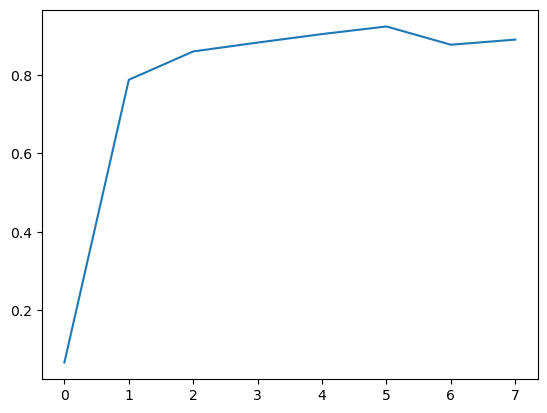

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:03.072061
In _add_node: add @7 38-m 45
In _add_node: add @8 57-m 38
In _add_node: add @9 31-m 38
In _add_node: add @10 51-m 35
In _add_node: add @12 55-m 32
In _add_node: add @14 49-m 26
In _add_node: add @0 34-7 100 B->A]^ 26/10 attn
In _add_node: add @1 31-50 93 B->A]^ 64/52 attn
In _add_node: add @2 37-47 76 B->A]^ 60/42 attn
In _add_node: add @3 45-36 61 B->A]^ 43/34 attn
In _add_node: add @4 40-21 60 B->A]^ 47/21 attn
In _add_node: add @5 43-36 58 B->A]^ 63/22 attn
In _add_node: add @6 28-34 45 B->A]^ 50/42 attn
In _add_node: add @11 58-13 35 B->A]^ 49/21 attn
In _add_node: add @13 32-12 27 B->A]^ 52/23 attn
In _add_node: add @[7,8,9,10,12,14] 38-m,57-m,31-m,51-m,55-m,49-m 26 B->B 41
In _add_node: add @[0,1,2,3,4,5,6,11,13] 34-7,31-50,37-47,45-36,40-21,43-36,28-34,58-13,32-12 27 B->A]^ 30
In _add_node: add 34-7 B->A]^ attn
In attribute_tree: attribute_step 34-7 B->A]^ attn ... done 0:00:02.120450
In _add_node: add

In attribute_tree: attribute_step 17-18 B->Q] ... done 0:00:01.161544
In _add_node: add @1 15-40 86 Q]->Q] 2/6/-27
In _add_node: add @2 15-22 58 Q]->Q] 2/4/-33
In _add_node: add @9 12-m 33
In _add_node: add @13 8-1 29 Q]->Q] 1/3/-281
In _add_node: add @0 16-17 100 Q]->A]^ 15/27/100 attn
In _add_node: add @0 16-17 100 Q]->A]^ 15/27/100
In _add_node: add @3 15-7 55 Q]->A]^ 5/7/100 attn
In _add_node: add @3 15-7 55 Q]->A]^ 5/7/100
In _add_node: add @4 11-1 47 Q]->A]^ 4/4/100 attn
In _add_node: add @4 11-1 47 Q]->A]^ 4/4/100
In _add_node: add @5 13-46 43 Q]->A]^ 1/2/100 attn
In _add_node: add @5 13-46 43 Q]->A]^ 1/2/100
In _add_node: add @7 12-18 39 Q]->A]^ 7/13/100 attn
In _add_node: add @7 12-18 39 Q]->A]^ 7/13/100
In _add_node: add @8 8-34 34 Q]->A]^ 2/2/100 attn
In _add_node: add @8 8-34 34 Q]->A]^ 2/2/100
In _add_node: add @10 14-16 33 Q]->A]^ 3/4/100 attn
In _add_node: add @10 14-16 33 Q]->A]^ 3/4/100
In _add_node: add @11 14-27 33 Q]->A]^ 1/1/100 attn
In _add_node: add @11 14-27 33 

In [15]:
# result = {}
# save_results = False 
# rel1_kwargs = {'x_f': None} 
# for i in range(0,n_total,batch_size):
#     mathlogic_dataset = []
#     all_examples = make_example_ml(input_strs[i:i+batch_size],nrows,g2c)
#     mathlogic_dataset.append(tuple(all_examples))
#     mathlogic_dataset.append(tuple(text[i:i+batch_size]))
#     mathlogic_dataset.append(tuple([tuple(['a' for _ in range(nrows)]) for _ in range(batch_size)]))
# #     print(mathlogic_dataset)
#     r = None
#     r = generate_and_predict_batch(model, tokenizer, task= None, nrows = nrows, k_shot = k_shot, batch_size = batch_size,
#                                    mathlogic_dataset = mathlogic_dataset, result=r, verbose=False)
#     if True or r.root is None:
#         r.root = node = add_node(None, layer=L, label_type='labels')
# #         ap = 'query1->query0+' 
# #         node = add_node(r.root, layer=9, head=36, attn_pattern=ap,label_type= None,H=H,step=2,force=True)
# #         node.data.top_score = node.data.ap_score = 0.
#     _ = attribute_tree_on(r.data_tuples, model, node, 8, filter_fn_nrk, topk=15, threshold_score=0, k_shot=k_shot, mix=True, device=None, verbose=True )

In [16]:
print_tree(r.root) 

 ┌@[7,8,9,10,12,14] 38-m,57-m,31-m,51-m,55-m,49-m 26 B->B 41
 ├@[0,1,2,3,4,5,6,11,13] 34-7,31-50,37-47,45-36,40-21,43-36,28-34,58-13,32-12 27 B->A]^ 30
 ├@7 38-m 45
 ├@8 57-m 38
 ├@9 31-m 38
 ├@10 51-m 35
 ├@12 55-m 32
 ├@14 49-m 26
 ├@0 34-7 100 B->A]^ 26/10 attn
 ├@1 31-50 93 B->A]^ 64/52 attn
 ├@2 37-47 76 B->A]^ 60/42 attn
 ├@3 45-36 61 B->A]^ 43/34 attn
 ├@4 40-21 60 B->A]^ 47/21 attn
 ├@5 43-36 58 B->A]^ 63/22 attn
 ├@6 28-34 45 B->A]^ 50/42 attn
 ├@11 58-13 35 B->A]^ 49/21 attn
 ├@13 32-12 27 B->A]^ 52/23 attn
 ┤
 │                ┌@[0,2,3,4,6,7,9,10,11,12,13] 26-51,26-13,23-27,10-13,11-1,26-27,24-34,13-29,16-17,15-4 27,20-45 26 B->A]^ 35
 │                ├@[5,8,14] 24-51,32-47,18-13 26 B->Q+ 10
 │                ├@[1] 27-m B->B 10
 │                ├@0 26-51 100 B->A]^ 36/23 attn
 │                ├@2 26-13 77 B->A]^ 61/51 attn
 │                ├@3 23-27 68 B->A]^ 54/30 attn
 │                ├@4 10-13 59 B->A]^ 22/18 attn
 │                ├@6 11-1 49 B->A]^ 71/39 attn
 │   

In [31]:
#修改filter_fn, 满足条件才可以往后归
# def filter_fn_nrk(p, c):
#     if c.layer == 0: return False
# #     if p.label_type and 'attn_labels' in p.label_type and '->~<s>' in p.label_type: return False
#     pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
#     return (p.step == -1  and c.top_score > 0.4 and c.head != c.H or
#             p.step == 0 and c.top_score > 0.5 and c.head != c.H or# and c.top_score > 0.3 and c.ap_score > 0.4 and ap == 'B->A]^' and c.head != c.H or
#             p.step == 1 and c.top_score > 0.4 and c.head != c.H and ap == 'B->Q1' or
#             p.step == 2 and c.top_score > 0.5 and c.ap_score > 0.1 and c.head != c.H and p.label_type != 'attn_labels' and c.label_type != 'attn_labels' and ap not in ['Q1->A]^','Q1->Q1]^'] or
#             p.step == 3 and c.top_score > 0.5 and c.ap_score > 0.3 and c.head != c.H and c.label_type != 'attn_labels' or ap == 'B->Q1' or
#             p.step == 4 and c.top_score > 0.4 and c.ap_score > 0.1 and c.head != c.H and c.label_type != 'attn_labels'or (ap in ['Q1+->Q1'] and c.top_score > 0.4 and c.ap_score > 0)
            
# #             p.step == 3 and ap in ['Q1->Q1-','Q1->Q0-'] 
# #             p.step == 4 and ap in ['Q1-->Q0-'] or 
# #             p.step == 5 and ap == 'Q0-->Q1+^'

#     )
def filter_fn_nrk(p, c):
    if c.layer == 0: return False

#     if p.label_type and 'attn_labels' in p.label_type and '->~<s>' in p.label_type: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (
#             p.step == -1 #and (c.layer, c.head) in [(59,4),(37,52)] #or
#             p.step == 0 and (c.layer, c.head) in [(18,18),(19,24)] and c.label_type != None and c.label_type.startswith('attn_labels:') or
#             p.step == 1 and ap == 'B->A]^'
        
#             p.step == -1 and (c.layer, c.head) in [(36,52)] or
#             p.step == 0 and (c.layer, c.head) in [(24,52)] or #(24,52),(26,49)
#             p.step == 1 and (c.layer, c.head) in [(18,52)] or
#             p.step == 2 and ap in ['B->Q]','B->A]'] and c.label_type != None and c.label_type.startswith('attn_labels:') and c.ap_score>0.1 or
#             p.step == 3 and (c.layer, c.head) in [(14,42),(16,5)]
        
#             p.step == -1 and (c.layer, c.head) in [(26,23)] and c.label_type != 'attn_labels' or
#             p.step == 0 and (c.layer, c.head) in [(19,28),(15,0),(18,13),(16,5),(16,10),(11,1)] and c.label_type == None
        
#             p.step == -1 and (c.layer,c.head) in [(36,52)] or #(44,52),(45,52),(36,52)
#             p.step == 0 and (c.layer,c.head) in [(24,52)] or
#             p.step == 1 and (c.layer,c.head) == (16,24) or
#             p.step == 2 and c.ap_score > 0.1 and ap in ['A]->A0]','A]->Q]']
         
            
#             p.step == -1 and c.top_score>0.5 and (c.layer,c.head) in [(59,4),(37,52)] or  #< Ruth has a Violin. Carol has a Beetle. Ronald has Blueberries. >. Ruth has a kind of musical instrument
#             p.step == 0 and (c.layer,c.head) in [(28,8),(18,18),(19,24)] and c.label_type != 'attn_labels' or
#             p.step == 1 and (c.layer,c.head) in [(15,0),(17,32),(16,16)] #or
#             p.step == 2 and c.top_score>0.5
        
            p.step == -1 and c.top_score>0.5 and (c.layer,c.head)  in [(36,c.H)] or# Is elephant a kind of Animals?Yes
            p.step == 0 and (c.layer,c.head) in [(24,c.H)] or
            p.step == 1 and (c.layer,c.head) in [(18,22),(15,50)] and c.label_type == None or
            p.step == 2 and (c.layer,c.head) in [(14,52)] or
            p.step == 3 and c.top_score>0.7
        
        
#             p.step == -1 and (c.layer,c.head) == (34,7) or   
#             p.step == 0 and (c.layer,c.head) in [(27,52),(26,51),(24,51)] or
#             p.step == 1 and (c.layer,c.head) in [(24,35),(22,52),(15,0)] or
#             p.step == 2 and (c.layer,c.head) in [(12,8),(17,18)]
        
#             p.step == -1 and (c.layer,c.head) in [(43,52),(36,52)] or
#             p.step == 0 and (c.layer,c.head) in [(28,52),(38,52),(34,52),(24,52)] or
#             p.step == 1 and (c.layer,c.head) in [(22,52),(33,52)] or
#             p.step == 2 and (c.layer,c.head) in [(18,22),(17,10)] and c.label_type == None
        
        
#             p.step == -1 and c.top_score>0.5 or
#             p.step == 0 and c.top_score>0.5 or
#             p.step == 1 and ap in ['B->Q+','B->R]']
        
         
#             p.step == -1  and (c.layer,c.head) in [(45,52),(36,52)] or # attribute q of (31-50，26-13)
#             p.step == 0  and ((c.layer,c.head) in [(31,50),(26,13)] and c.label_type != None) or
#             p.step == 1 and (c.layer,c.head) == (22,52) and c.label_type == None or
#             p.step == 2 and c.top_score>0.4 and c.ap_score>0.3 and c.head != c.H or
#             p.step == 3 and (c.layer,c.head) == (14,7)
        
        
#             p.step == -1  and (c.layer,c.head) in [(45,52),(36,52)] or # attribute v of g2c
#             p.step == 0  and ((c.layer,c.head) in [(20,52),(27,52)] or ((c.layer,c.head) in [(30,46),(26,49)] and c.label_type != None)) or
#             p.step == 1 and (c.layer,c.head) in [(11,17),(18,22),(26,51),(24,34)] and c.label_type == None or
#             p.step == 2 and c.top_score>0.5 and c.ap_score > 0.2 and c.label_type == None
#             
           )

In [9]:
# # #老师的样例
tasks0 = [
#     (lambda: [TreeSet(types_of_things).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#     ),
#     (lambda: [TreeSet(types_of_things).use(['equal']), TreeSet(types_of_things).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ),
#     (lambda: [TreeSet(genders_of_persons).use(['equal']), TreeSet(genders_of_persons).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"Is {q} a",
#     ),
    (lambda: [TreeSet(countries_of_cities).use(['equal']), TreeSet(countries_of_cities).use(['child'])], MlM_gen,
     lambda *args, **kwargs: '',lambda q, _: f"{q} is",# lambda q, _: f"{q} is",
    ),
    (lambda: [TreeSet(country2capital).use(['equal']), TreeSet(country2capital).use(['child'])], MlM_gen,
     lambda *args, **kwargs: '',lambda q, _: f"{q} is",# lambda q, _: f"{q} is",
    ),
    (lambda: [TreeSet(types_of_things).use(['equal']), TreeSet(types_of_things).use(['child'])], MlM_gen,
     lambda *args, **kwargs: '', lambda q, _: f"Is {q} ",
    ),
]

tasks = [
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), SymSet(person_adjs).use(['opposite'])], MlM_gen,
     partial(_cxt2str,item2str=lambda i, _: [f"{i[0]} is {i[1]}.", f"{capitalize(i[1])} {i[0]}."]), lambda q, _: f"{the_(q)} is",
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(capabilities_of_things).use(['child'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"{the_(q)} has",
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"Does {the_(q)} have",
    ), #Does {the_(q)} have  /  {the_(q)} has
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}.", f"{i[1]} attracts {the_(i[0], uppercase=False)}."]), lambda q, _: f'Would {the_(q)} like to visit',
    ), # Would {the_(q)} like to visit / {the_(q)} want to go to
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(country2capital).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}.", f"{i[1]} attracts {the_(i[0], uppercase=False)}."]), lambda q, _: f'Would {the_(q)} like to visit',
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['prev'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}.', f'{capitalize(prep_(i[1]))} arrived {i[0]}.']), lambda q, _: f'{the_(q)} arrived'
    ),
    
]

#find the key of value
def get_key(dict_data,value):
    loc = [1 if value in i else 0 for i in list(dict_data.values())]
    key=list(dict_data.keys())[loc.index(1)]
    return key

In [42]:
results = {}; key = None


== g2c[MlM_gen][genders_of_persons.TreeSet.equal,types_of_things.TreeSet.child][cxt_len=3] == do_g2c
< David has a rabbit. Sharon has a jacket. Barbara has bread. >. Does Barbara possess a kind of food? Yes
 < Kevin has underwear. Paul has a duck. Susan has a papaya. >. Does Kevin possess a kind of clothing? Yes
 < Richard has shoes. Sharon has a beetle. John has strawberries. >. Does Sharon possess a kind of fruit? No
0.47004513144493104 0.8 0.7813500000000001


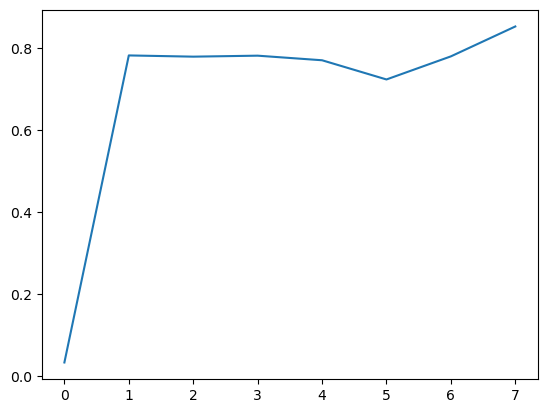

In [43]:
nrows, k_shot = 8, 2; cxt_len = 3; save_results = True # key is not None
batch_size = 10; verbose=False #not save_results or batch_size <= 8
rel1_kwargs = {'x_f': None}  # {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}
for task,        rel0_i, rel1_i, do_swap_qa, do_negate, do_rm_query, rev_item2str, do_g2c in product(
    tasks[2:3],[0,],[0],[False,],[False,],[False],[False],[True]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_i=rel0_i, rel1_i=rel1_i, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_query=do_rm_query, do_g2c=do_g2c)
    task = transform_and_validate_task(task, **trans_args, **args)
#     if task[0]()[1].relations[0].name == 'equal': continue
    if task is None: continue
    res_key = f'{task2str(task)}[{args2str(args)}]'  # {composed_heads2str(model)}
#     if key and res_key != key: continue
    print(f'\n== {res_key} == {args2str(trans_args)}')
    r = results[res_key] if save_results and res_key in results else None
#     if r is not None: print('duplicate task!'); continue 
    r = generate_and_predict_batch(model if save_results else model_gpu, tokenizer, task, nrows, k_shot, batch_size,
            logits_bias=None, custom_forward=True or save_results, result=r, verbose=verbose, **args)
    if save_results: results[res_key] = r
#     elif True or r.mean_acc < 0.6: continue
        
#     if True or r.root is None:
#         r.root = node = add_node(None, layer=L, label_type='labels')
#     _ = attribute_tree_on(r.data_tuples, model, node, 1, filter_fn_nrk, topk=15, k_shot=k_shot, mix=True, device=None, verbose=True)

In [41]:
print_tree(r.root)

 ┌@[0,2,3,5,6,8,10] 59-m,25-m,44-m,36-m,45-m,51-m,34-m B->B 58
 ├@[1,4,7,9,12] 36-26,38-22,31-50,29-34,39-40 B->C^ 15
 ├@[11] 32-21 unk 0
 ├@0 59-m 100
 ├@2 25-m 73
 ├@3 44-m 73
 ├@5 36-m 62
 ├@6 45-m 54
 ├@8 51-m 36
 ├@10 34-m 31
 ├@1 36-26 92 B->C^ 41/21/100 attn
 ├@1 36-26 92 B->C^ 41/21/100
 ├@4 38-22 64 B->C^ 40/36/100 attn
 ├@4 38-22 64 B->C^ 40/36/100
 ├@7 31-50 53 B->C^ 51/41/100 attn
 ├@7 31-50 53 B->C^ 51/41/100
 ├@9 29-34 32 B->C^ 52/25/100 attn
 ├@9 29-34 32 B->C^ 52/25/100
 ├@12 39-40 30 B->C^ 41/17/100 attn
 ├@12 39-40 30 B->C^ 41/17/100
 ├@11 32-21 30 B->A] 65/25 attn
 ├@11 32-21 30 B->A] 65/25
 ┤
 │         ┌@[1,2,3,4,5] 24-m,20-m,27-m,23-m,29-m B->B 54
 │         ├@[0] 36-26 B->C^ 18
 │         ├@1 24-m 61
 │         ├@2 20-m 58
 │         ├@3 27-m 39
 │         ├@4 23-m 34
 │         ├@5 29-m 34
 │         ├@0 36-26 100 B->C^ 42/21/100 attn
 │         ├@0 36-26 100 B->C^ 42/21/100
 └36-m B->B┤
           │         ┌@[0,1,2,5] 19-m,21-m,22-m,15-m B->B 39
           │  

In [52]:
node = r.root.children[-1].children[-1]#.children[-1].children[-1]#.children[-1]#.children[-1].children[-1]
node.name

44-52
scaled_logprobs = tensor([-0.6934, -0.6099, -0.5347, -0.4680, -0.4092, -0.3574], device='cuda:0',
       dtype=torch.float16)
 ▁Yes 0.411 {'▁No': 0.588, '▁Yes': 0.412, '<unk>': 0.0, '<s>': 0.0} 	 < David has a rabbit. Sharon has a jacket. Barbara has bread. >. Does Barbara possess a kind of food? Yes ▁No:0.161 *▁Yes:-0.197
 ▁Yes 0.211 {'▁No': 0.788, '▁Yes': 0.211, '<unk>': 0.0, '<s>': 0.0} 	  < Kevin has underwear. Paul has a duck. Susan has a papaya. >. Does Kevin possess a kind of clothing? Yes ▁No:1.144 *▁Yes:-0.172
*▁No 0.781 {'▁No': 0.781, '▁Yes': 0.219, '<unk>': 0.0, '<s>': 0.0} 	  < Richard has shoes. Sharon has a beetle. John has strawberries. >. Does Sharon possess a kind of fruit? No *▁No:1.155 ▁Yes:-0.115
*▁Yes 0.733 {'▁Yes': 0.734, '▁No': 0.266, '<unk>': 0.0, '<s>': 0.0} 	  < Barbara has spaghetti. Margaret has a cocktail. John has a banana. >. Does John possess a kind of fruit? Yes ▁No:-0.627 *▁Yes:0.385
*▁Yes 0.563 {'▁Yes': 0.564, '▁No': 0.436, '<unk>': 0.0, '<s>': 

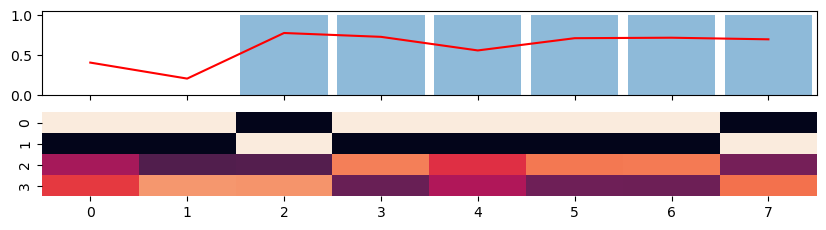

scaled_logprobs = tensor([-0.6934, -0.6724, -0.6558, -0.6421, -0.6328, -0.6265], device='cuda:0',
       dtype=torch.float16)
*▁No 0.732 {'▁No': 0.732, '▁Yes': 0.268, '<unk>': 0.0, '<s>': 0.0} 	 < Charles has a rabbit. Sandra has a taxi. Daniel has a shotgun. >. Does Daniel have a kind of animal? No *▁No:0.810 ▁Yes:-0.195
*▁No 0.784 {'▁No': 0.784, '▁Yes': 0.216, '<unk>': 0.0, '<s>': 0.0} 	  < Carol has a rifle. Maria has sheep. David has a mango. >. Does Carol have a kind of animal? No *▁No:1.223 ▁Yes:-0.067
*▁Yes 0.567 {'▁Yes': 0.567, '▁No': 0.433, '<unk>': 0.0, '<s>': 0.0} 	  < Kenneth has meat. Susan has an apricot. Charles has a handgun. >. Does Kenneth have a kind of food? Yes ▁No:-0.022 *▁Yes:0.247
*▁No 0.6 {'▁No': 0.6, '▁Yes': 0.4, '<unk>': 0.0, '<s>': 0.0} 	  < David has a hamburger. Kevin has a dog. Donald has a plum. >. Does Kevin have a kind of fruit? No *▁No:0.484 ▁Yes:0.081
*▁Yes 0.718 {'▁Yes': 0.718, '▁No': 0.282, '<unk>': 0.0, '<s>': 0.0} 	  < Betty has spaghetti. Steven

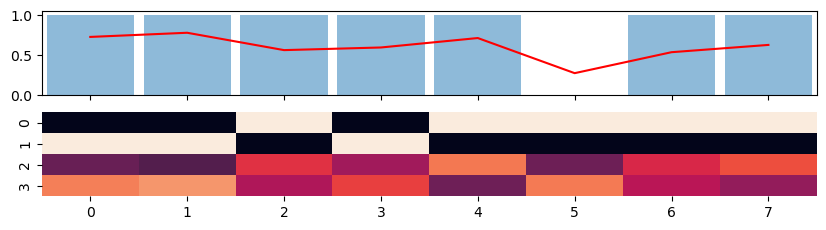

scaled_logprobs = tensor([-0.6934, -0.6611, -0.6372, -0.6221, -0.6138, -0.6128], device='cuda:0',
       dtype=torch.float16)
*▁No 0.825 {'▁No': 0.825, '▁Yes': 0.175, '<unk>': 0.0, '<s>': 0.0} 	 < Maria has a goat. George has a football. Carol has a pear. >. Does George own a kind of animal? No *▁No:1.212 ▁Yes:-0.339
 ▁Yes 0.457 {'▁No': 0.543, '▁Yes': 0.457, '<unk>': 0.0, '<s>': 0.0} 	  < John has a mango. Barbara has a lime. Karen has a rifle. >. Does Karen own a kind of weapon? Yes ▁No:0.317 *▁Yes:0.146
 ▁Yes 0.319 {'▁No': 0.68, '▁Yes': 0.319, '<unk>': 0.0, '<s>': 0.0} 	  < James has a grenade. Michelle has strawberries. Sharon has a football. >. Does Sharon own a kind of sport? Yes ▁No:0.746 *▁Yes:-0.012
*▁No 0.831 {'▁No': 0.831, '▁Yes': 0.169, '<unk>': 0.0, '<s>': 0.0} 	  < Linda has a costume. Dorothy has a rabbit. Robert has a basketball. >. Does Robert own a kind of clothing? No *▁No:1.302 ▁Yes:-0.291
 ▁Yes 0.331 {'▁No': 0.67, '▁Yes': 0.331, '<unk>': 0.0, '<s>': 0.0} 	  < Steven

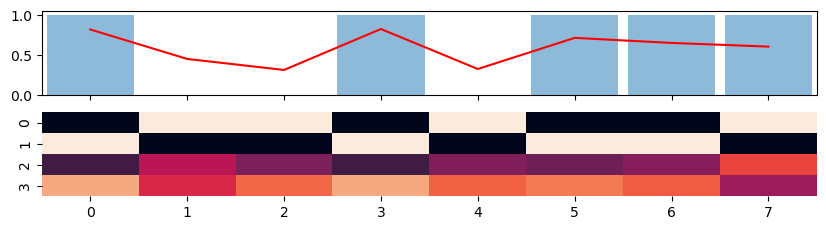

scaled_logprobs = tensor([-0.6934, -0.6680, -0.6494, -0.6362, -0.6279, -0.6250], device='cuda:0',
       dtype=torch.float16)
*▁No 0.524 {'▁No': 0.524, '▁Yes': 0.476, '<unk>': 0.0, '<s>': 0.0} 	 < Jason has a beetle. Kevin has a goat. David has a papaya. >. Does Jason possess a kind of animal? No *▁No:0.143 ▁Yes:0.045
 ▁Yes 0.428 {'▁No': 0.572, '▁Yes': 0.428, '<unk>': 0.0, '<s>': 0.0} 	  < Mark has a lime. Joseph has a violin. Carol has wine. >. Does Joseph possess a kind of musical instrument? Yes ▁No:0.494 *▁Yes:0.204
*▁No 0.771 {'▁No': 0.771, '▁Yes': 0.229, '<unk>': 0.0, '<s>': 0.0} 	  < Elizabeth has a car. James has a violin. Donna has coffee. >. Does Elizabeth possess a kind of drink? No *▁No:1.046 ▁Yes:-0.167
 ▁Yes 0.486 {'▁No': 0.514, '▁Yes': 0.486, '<unk>': 0.0, '<s>': 0.0} 	  < Elizabeth has a guitar. William has a taxi. Edward has a banana. >. Does William possess a kind of vehicle? Yes ▁No:0.275 *▁Yes:0.219
*▁Yes 0.611 {'▁Yes': 0.612, '▁No': 0.389, '<unk>': 0.0, '<s>': 0.0}

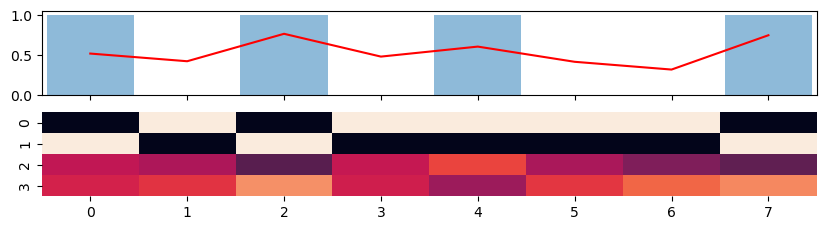

scaled_logprobs = tensor([-0.6934, -0.6372, -0.5874, -0.5444, -0.5078, -0.4766], device='cuda:0',
       dtype=torch.float16)
 ▁Yes 0.469 {'▁No': 0.531, '▁Yes': 0.469, '<unk>': 0.0, '<s>': 0.0} 	 < Maria has a mango. Barbara has T-shirt. Donna has a watermelon. >. Does Barbara possess a kind of clothing? Yes ▁No:0.005 *▁Yes:-0.119
*▁No 0.891 {'▁No': 0.89, '▁Yes': 0.109, '<unk>': 0.0, '<s>': 0.0} 	  < Elizabeth has coffee. Anthony has a shirt. Kevin has a taxi. >. Does Kevin possess a kind of clothing? No *▁No:1.546 ▁Yes:-0.551
 ▁Yes 0.425 {'▁No': 0.575, '▁Yes': 0.425, '<unk>': 0.0, '<s>': 0.0} 	  < Susan has a jeep. Deborah has a pig. Sharon has a handgun. >. Does Deborah possess a kind of animal? Yes ▁No:0.394 *▁Yes:0.091
*▁Yes 0.606 {'▁Yes': 0.606, '▁No': 0.394, '<unk>': 0.0, '<s>': 0.0} 	  < Jeff has a guitar. Maria has jeans. Thomas has a bee. >. Does Maria possess a kind of clothing? Yes ▁No:-0.189 *▁Yes:0.242
*▁No 0.54 {'▁No': 0.54, '▁Yes': 0.46, '<unk>': 0.0, '<s>': 0.0} 	  < Li

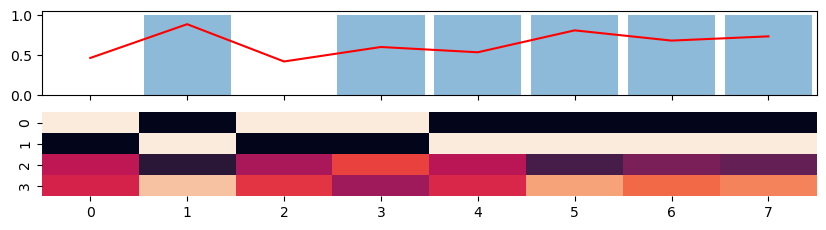

scaled_logprobs = tensor([-0.6934, -0.6987, -0.7085, -0.7227, -0.7407, -0.7637], device='cuda:0',
       dtype=torch.float16)
*▁No 0.738 {'▁No': 0.738, '▁Yes': 0.262, '<unk>': 0.0, '<s>': 0.0} 	 < Jennifer has a gun. James has a football. Margaret has a bus. >. Does Margaret own a kind of sport? No *▁No:0.816 ▁Yes:-0.217
*▁Yes 0.611 {'▁Yes': 0.612, '▁No': 0.388, '<unk>': 0.0, '<s>': 0.0} 	  < Michelle has a burger. Helen has a papaya. Carol has a cannon. >. Does Michelle own a kind of food? Yes ▁No:-0.113 *▁Yes:0.341
*▁Yes 0.506 {'▁Yes': 0.506, '▁No': 0.494, '<unk>': 0.0, '<s>': 0.0} 	  < Charles has a papaya. Maria has a revolver. Nancy has a costume. >. Does Maria own a kind of weapon? Yes ▁No:0.114 *▁Yes:0.140
*▁Yes 0.583 {'▁Yes': 0.584, '▁No': 0.416, '<unk>': 0.0, '<s>': 0.0} 	  < Linda has a pig. Dorothy has a sweater. Maria has a dog. >. Does Dorothy own a kind of clothing? Yes ▁No:-0.125 *▁Yes:0.213
 ▁Yes 0.275 {'▁No': 0.724, '▁Yes': 0.276, '<unk>': 0.0, '<s>': 0.0} 	  < Linda h

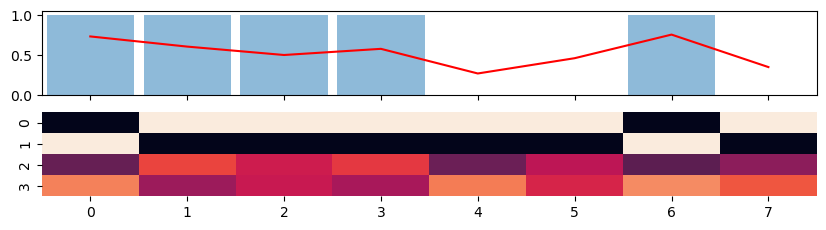

scaled_logprobs = tensor([-0.6934, -0.6323, -0.5757, -0.5234, -0.4746, -0.4299], device='cuda:0',
       dtype=torch.float16)
*▁No 0.794 {'▁No': 0.794, '▁Yes': 0.206, '<unk>': 0.0, '<s>': 0.0} 	 < Carol has a kiwi. Sharon has a sweater. Sarah has a basketball. >. Does Sharon own a kind of fruit? No *▁No:0.957 ▁Yes:-0.392
 ▁Yes 0.46 {'▁No': 0.54, '▁Yes': 0.46, '<unk>': 0.0, '<s>': 0.0} 	  < Steven has trousers. Barbara has a banana. Sharon has wine. >. Does Sharon own a kind of drink? Yes ▁No:0.339 *▁Yes:0.178
*▁No 0.655 {'▁No': 0.656, '▁Yes': 0.345, '<unk>': 0.0, '<s>': 0.0} 	  < Christopher has a lemon. Carol has a cannon. Edward has a tiger. >. Does Carol own a kind of fruit? No *▁No:0.607 ▁Yes:-0.036
*▁No 0.727 {'▁No': 0.727, '▁Yes': 0.273, '<unk>': 0.0, '<s>': 0.0} 	  < Mark has a guitar. George has a watermelon. Ronald has a taxi. >. Does Mark own a kind of vehicle? No *▁No:0.852 ▁Yes:-0.128
*▁No 0.652 {'▁No': 0.652, '▁Yes': 0.348, '<unk>': 0.0, '<s>': 0.0} 	  < Sandra has blueber

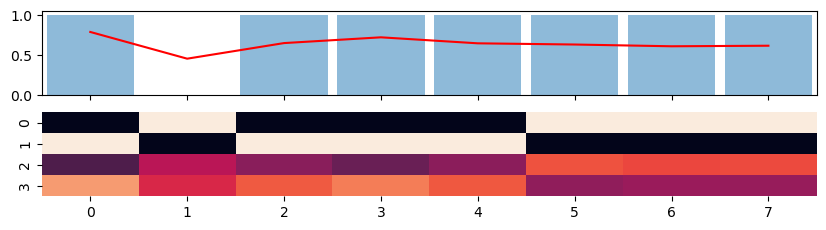

scaled_logprobs = tensor([-0.6934, -0.6421, -0.5952, -0.5513, -0.5112, -0.4744], device='cuda:0',
       dtype=torch.float16)
 ▁Yes 0.425 {'▁No': 0.574, '▁Yes': 0.425, '<unk>': 0.0, '<s>': 0.0} 	 < Dorothy has a pig. Robert has a plum. Barbara has a basketball. >. Does Barbara possess a kind of sport? Yes ▁No:0.155 *▁Yes:-0.146
*▁No 0.93 {'▁No': 0.93, '▁Yes': 0.07, '<unk>': 0.0, '<s>': 0.0} 	  < Nancy has blackberries. Dorothy has a gun. Elizabeth has a sweater. >. Does Elizabeth possess a kind of weapon? No *▁No:2.033 ▁Yes:-0.554
*▁Yes 0.763 {'▁Yes': 0.763, '▁No': 0.237, '<unk>': 0.0, '<s>': 0.0} 	  < Deborah has a pistol. Nancy has a jersey. Thomas has underwear. >. Does Deborah possess a kind of weapon? Yes ▁No:-0.795 *▁Yes:0.375
*▁No 0.557 {'▁No': 0.557, '▁Yes': 0.443, '<unk>': 0.0, '<s>': 0.0} 	  < Linda has a violin. Michelle has a lemon. William has bread. >. Does Linda possess a kind of food? No *▁No:0.356 ▁Yes:0.127
*▁Yes 0.619 {'▁Yes': 0.619, '▁No': 0.38, '<unk>': 0.0, '<s>':

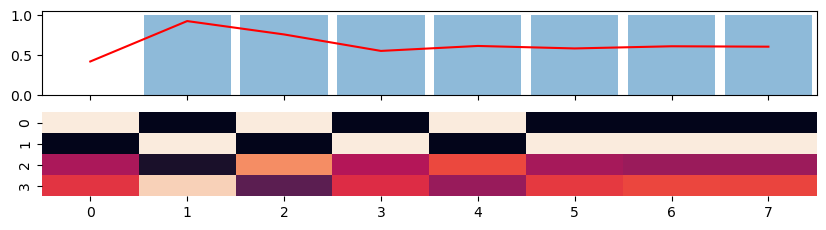

scaled_logprobs = tensor([-0.6934, -0.6606, -0.6313, -0.6040, -0.5806, -0.5591], device='cuda:0',
       dtype=torch.float16)
*▁No 0.623 {'▁No': 0.622, '▁Yes': 0.377, '<unk>': 0.0, '<s>': 0.0} 	 < Kevin has an elephant. Mark has a violin. Margaret has spaghetti. >. Does Kevin have a kind of food? No *▁No:0.378 ▁Yes:-0.123
*▁No 0.619 {'▁No': 0.618, '▁Yes': 0.381, '<unk>': 0.0, '<s>': 0.0} 	  < Barbara has a steak. Elizabeth has a car. Joseph has a rabbit. >. Does Barbara have a kind of animal? No *▁No:0.554 ▁Yes:0.070
*▁No 0.714 {'▁No': 0.714, '▁Yes': 0.286, '<unk>': 0.0, '<s>': 0.0} 	  < David has a rifle. Edward has a uniform. James has whiskey. >. Does David have a kind of clothing? No *▁No:0.947 ▁Yes:0.030
*▁No 0.576 {'▁No': 0.576, '▁Yes': 0.424, '<unk>': 0.0, '<s>': 0.0} 	  < Barbara has a shirt. Betty has vodka. Margaret has a football. >. Does Barbara have a kind of drink? No *▁No:0.520 ▁Yes:0.214
*▁No 0.621 {'▁No': 0.62, '▁Yes': 0.38, '<unk>': 0.0, '<s>': 0.0} 	  < Linda has a p

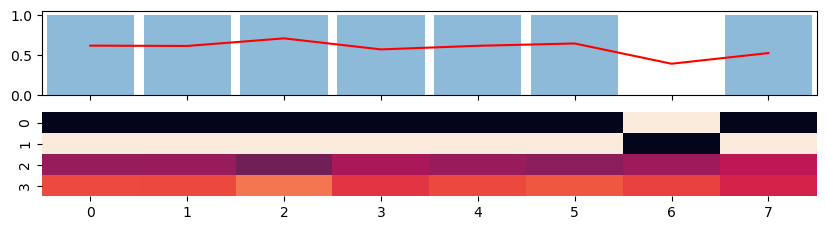

scaled_logprobs = tensor([-0.6934, -0.6782, -0.6665, -0.6582, -0.6533, -0.6509], device='cuda:0',
       dtype=torch.float16)
*▁No 0.734 {'▁No': 0.734, '▁Yes': 0.266, '<unk>': 0.0, '<s>': 0.0} 	 < Richard has a steak. Kimberly has whiskey. Michael has a monkey. >. Does Michael own a kind of food? No *▁No:0.746 ▁Yes:-0.271
 ▁Yes 0.371 {'▁No': 0.629, '▁Yes': 0.371, '<unk>': 0.0, '<s>': 0.0} 	  < Joseph has T-shirt. Anthony has a peach. George has a football. >. Does George own a kind of sport? Yes ▁No:0.652 *▁Yes:0.125
 ▁Yes 0.436 {'▁No': 0.564, '▁Yes': 0.436, '<unk>': 0.0, '<s>': 0.0} 	  < Linda has a banana. Mark has a mosquito. Anthony has a cow. >. Does Anthony own a kind of animal? Yes ▁No:0.355 *▁Yes:0.097
*▁No 0.79 {'▁No': 0.79, '▁Yes': 0.21, '<unk>': 0.0, '<s>': 0.0} 	  < Laura has a cannon. Kenneth has trousers. Daniel has a basketball. >. Does Kenneth own a kind of weapon? No *▁No:1.188 ▁Yes:-0.135
 ▁Yes 0.441 {'▁No': 0.558, '▁Yes': 0.442, '<unk>': 0.0, '<s>': 0.0} 	  < Michell

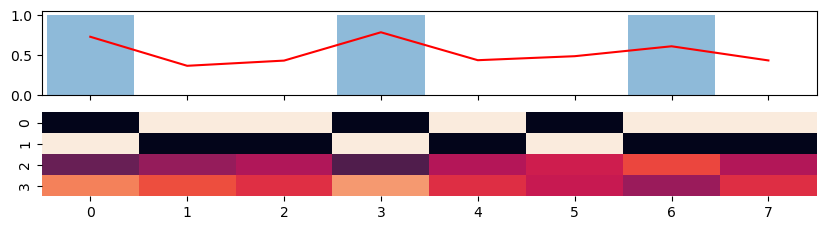

scaled_logprobs = tensor([-0.6934, -0.6406, -0.5928, -0.5503, -0.5117, -0.4778], device='cuda:0',
       dtype=torch.float16)
*▁No 0.612 {'▁No': 0.612, '▁Yes': 0.388, '<unk>': 0.0, '<s>': 0.0} 	 < Donna has wine. Donald has a jacket. Karen has a rabbit. >. Does Donald have a kind of drink? No *▁No:0.447 ▁Yes:-0.008
*▁No 0.659 {'▁No': 0.658, '▁Yes': 0.342, '<unk>': 0.0, '<s>': 0.0} 	  < David has a duck. Charles has a pear. Carol has a beetle. >. Does Carol have a kind of animal? No *▁No:0.680 ▁Yes:0.023
*▁No 0.59 {'▁No': 0.59, '▁Yes': 0.41, '<unk>': 0.0, '<s>': 0.0} 	  < Mary has an apricot. Lisa has a hamburger. John has vodka. >. Does John have a kind of fruit? No *▁No:0.580 ▁Yes:0.214
 ▁Yes 0.416 {'▁No': 0.584, '▁Yes': 0.416, '<unk>': 0.0, '<s>': 0.0} 	  < Ruth has a violin. Sandra has a durian. Mark has meat. >. Does Ruth have a kind of musical instrument? Yes ▁No:0.568 *▁Yes:0.228
*▁No 0.68 {'▁No': 0.68, '▁Yes': 0.32, '<unk>': 0.0, '<s>': 0.0} 	  < Betty has sheep. Ruth has a stea

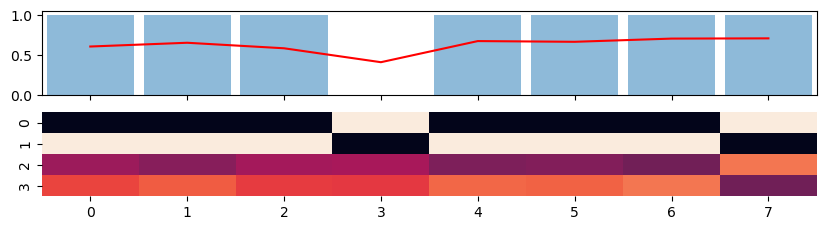

scaled_logprobs = tensor([-0.6934, -0.6147, -0.5474, -0.4895, -0.4402, -0.3984], device='cuda:0',
       dtype=torch.float16)
 ▁Yes 0.417 {'▁No': 0.583, '▁Yes': 0.417, '<unk>': 0.0, '<s>': 0.0} 	 < Dorothy has bread. Michael has a uniform. Richard has a squirrel. >. Does Dorothy have a kind of food? Yes ▁No:0.264 *▁Yes:-0.071
 ▁Yes 0.307 {'▁No': 0.694, '▁Yes': 0.307, '<unk>': 0.0, '<s>': 0.0} 	  < Karen has a car. Susan has juice. Kimberly has a goat. >. Does Susan have a kind of drink? Yes ▁No:0.778 *▁Yes:-0.037
 ▁Yes 0.492 {'▁No': 0.508, '▁Yes': 0.492, '<unk>': 0.0, '<s>': 0.0} 	  < Michelle has a uniform. Ronald has a beetle. Patricia has a tiger. >. Does Ronald have a kind of insect? Yes ▁No:0.284 *▁Yes:0.252
*▁No 0.881 {'▁No': 0.881, '▁Yes': 0.119, '<unk>': 0.0, '<s>': 0.0} 	  < William has a durian. Sarah has a grenade. Susan has an elephant. >. Does Susan have a kind of weapon? No *▁No:1.570 ▁Yes:-0.432
*▁No 0.61 {'▁No': 0.61, '▁Yes': 0.39, '<unk>': 0.0, '<s>': 0.0} 	  < Edward 

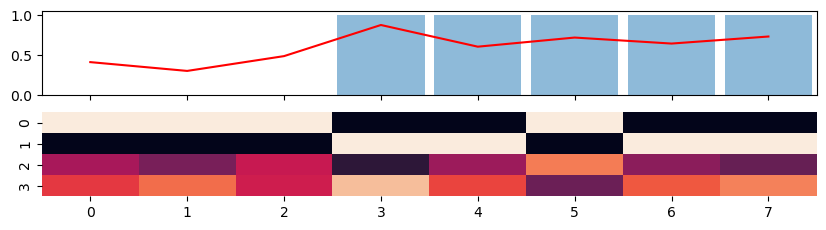

scaled_logprobs = tensor([-0.6934, -0.6973, -0.7070, -0.7212, -0.7402, -0.7632], device='cuda:0',
       dtype=torch.float16)
 ▁Yes 0.405 {'▁No': 0.594, '▁Yes': 0.405, '<unk>': 0.0, '<s>': 0.0} 	 < Brian has meat. Michelle has an apricot. Barbara has a bee. >. Does Brian possess a kind of food? Yes ▁No:0.440 *▁Yes:0.056
*▁No 0.908 {'▁No': 0.908, '▁Yes': 0.092, '<unk>': 0.0, '<s>': 0.0} 	  < Donna has blueberries. Edward has bread. Laura has a horse. >. Does Edward possess a kind of fruit? No *▁No:1.841 ▁Yes:-0.448
 ▁Yes 0.318 {'▁No': 0.682, '▁Yes': 0.318, '<unk>': 0.0, '<s>': 0.0} 	  < Robert has a pig. Edward has a football. Deborah has cake. >. Does Edward possess a kind of sport? Yes ▁No:0.719 *▁Yes:-0.042
 ▁Yes 0.41 {'▁No': 0.59, '▁Yes': 0.41, '<unk>': 0.0, '<s>': 0.0} 	  < Michael has a lime. Jeff has a monkey. Mary has a hamburger. >. Does Mary possess a kind of food? Yes ▁No:0.403 *▁Yes:0.041
 ▁Yes 0.427 {'▁No': 0.574, '▁Yes': 0.426, '<unk>': 0.0, '<s>': 0.0} 	  < Dorothy has a 

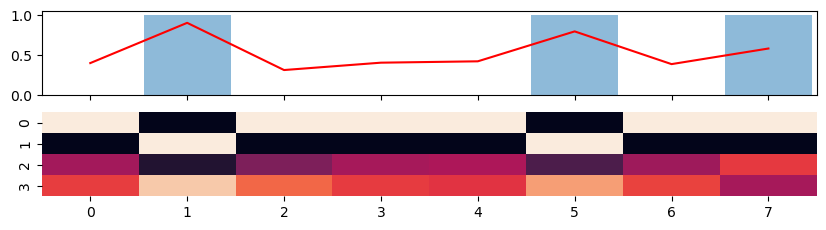

scaled_logprobs = tensor([-0.6934, -0.6890, -0.6875, -0.6890, -0.6919, -0.6987], device='cuda:0',
       dtype=torch.float16)
*▁No 0.775 {'▁No': 0.775, '▁Yes': 0.225, '<unk>': 0.0, '<s>': 0.0} 	 < Charles has cherries. Barbara has a pineapple. Kimberly has a shirt. >. Does Kimberly possess a kind of fruit? No *▁No:0.753 ▁Yes:-0.483
*▁No 0.831 {'▁No': 0.831, '▁Yes': 0.169, '<unk>': 0.0, '<s>': 0.0} 	  < Laura has a mosquito. Christopher has coffee. Joseph has a football. >. Does Laura possess a kind of sport? No *▁No:1.454 ▁Yes:-0.139
*▁No 0.549 {'▁No': 0.55, '▁Yes': 0.451, '<unk>': 0.0, '<s>': 0.0} 	  < Charles has a cat. Jeff has a basketball. Nancy has pizza. >. Does Jeff possess a kind of food? No *▁No:0.429 ▁Yes:0.231
*▁No 0.616 {'▁No': 0.616, '▁Yes': 0.384, '<unk>': 0.0, '<s>': 0.0} 	  < Ruth has an apple. Richard has underwear. Thomas has pizza. >. Does Richard possess a kind of food? No *▁No:0.655 ▁Yes:0.182
 ▁Yes 0.302 {'▁No': 0.698, '▁Yes': 0.302, '<unk>': 0.0, '<s>': 0.0} 	  

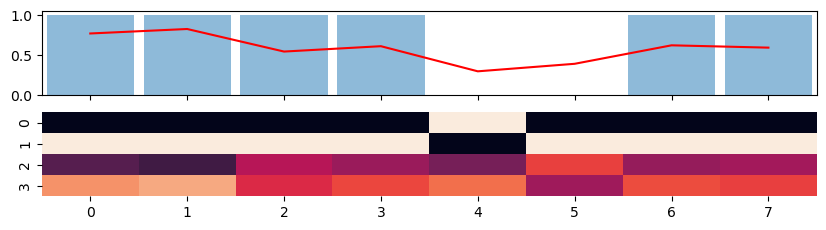

scaled_logprobs = tensor([-0.6934, -0.7114, -0.7319, -0.7534, -0.7769, -0.8013], device='cuda:0',
       dtype=torch.float16)
 ▁Yes 0.435 {'▁No': 0.564, '▁Yes': 0.435, '<unk>': 0.0, '<s>': 0.0} 	 < Elizabeth has bread. Brian has a mango. Nancy has a bus. >. Does Elizabeth have a kind of food? Yes ▁No:0.179 *▁Yes:-0.081
*▁No 0.897 {'▁No': 0.898, '▁Yes': 0.103, '<unk>': 0.0, '<s>': 0.0} 	  < John has bread. Barbara has a beetle. Linda has a taxi. >. Does Linda have a kind of insect? No *▁No:1.703 ▁Yes:-0.466
*▁Yes 0.621 {'▁Yes': 0.621, '▁No': 0.379, '<unk>': 0.0, '<s>': 0.0} 	  < Kenneth has sheep. Susan has a wolf. Michelle has a motorcycle. >. Does Michelle have a kind of vehicle? Yes ▁No:-0.296 *▁Yes:0.198
 ▁No 0.487 {'▁Yes': 0.512, '▁No': 0.487, '<unk>': 0.0, '<s>': 0.0} 	  < Elizabeth has a rifle. Donald has a piano. Donna has pants. >. Does Elizabeth have a kind of musical instrument? No *▁No:0.084 ▁Yes:0.136
 ▁No 0.446 {'▁Yes': 0.554, '▁No': 0.446, '<unk>': 0.0, '<s>': 0.0} 	  < C

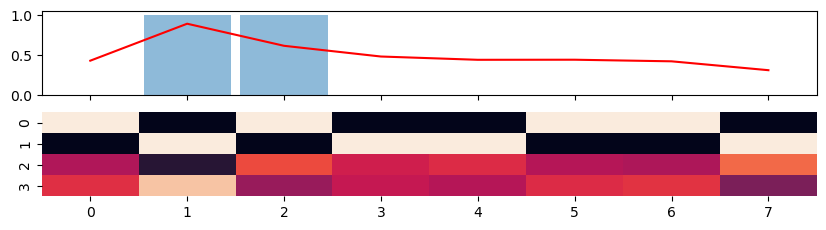

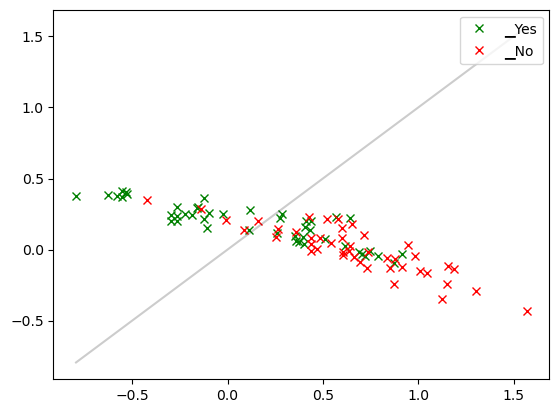

ratio = 0.766839
reduced_ap_scores = tensor([0.6050, 0.5039, 0.6899, 0.5718, 0.5698, 0.5464], device='cuda:0',
       dtype=torch.float16) tensor(0.5811, device='cuda:0', dtype=torch.float16)


In [45]:
plot_attn_attrs(r.data_tuples[:], model, tokenizer, node, topi=[3], attn_patterns=['B->B'], is_relating_head=False, k_shot=k_shot, mix=True)

In [51]:
plot_attn_attrs(r.data_tuples[:], model, tokenizer, node, topi=[0], attn_patterns=['B->B'], is_relating_head=False, k_shot=k_shot, mix=False)

In [41]:
from nrk.geometry.visualization_utils_modify import *
from plotly.subplots import make_subplots
from nrk.geometry.generate_acts import get_acts
#*************************

#注意查询attn和mlp的区别
#(layer = 10,pattern = 'attn')表示查询第10层输入，即第9层输出。(layer = 10,pattern = 'mlp')表示查询第10层mlp的输出
#pattern = 'attn'： layer 0~61
#pattern = 'mlp'： layer 0~59

#************************
layer = 36

fig = TruthData.from_datasets(
    ["typeofthing"],
    r,
    cxt_len,
    batch_size = batch_size,
    model_size = model_name,
    layer=layer,
    start=k_shot, 
    end=nrows,
    pattern = 'mlp',
    device=device
).plot(
    dimensions=2, # 3 dimensions also supported
    dim_offset=0, # increase if you want to ignore the first few PCs
    color='label',
    # if you don't want to plot and do PCA on all datasets:
    # plot_datasets = [ list of datasets to plot here ],
    # pca_datasets = [ list of datasets to use for PCA here]
)

fig.update_layout(
    title = {
        'text' : f"Dataset visualizations across layers {model_name}",
        'font' : {'size' : 20},
    }
)

fig.show()

In [44]:
from nrk.geometry.visualization_utils_modify import *
from plotly.subplots import make_subplots
from nrk.geometry.generate_acts import get_acts
#*************************

#注意查询attn和mlp的区别
#(layer = 10,pattern = 'attn')表示查询第10层输入，即第9层输出。(layer = 10,pattern = 'mlp')表示查询第10层mlp的输出
#pattern = 'attn'： layer 0~61
#pattern = 'mlp'： layer 0~59

#************************
layer = 36

fig = TruthData.from_datasets(
    ["typeofthing"],
    r,
    cxt_len,
    batch_size = batch_size,
    model_size = model_name,
    layer=layer,
    start=k_shot, 
    end=nrows,
    pattern = 'mlp',
    device=device
).plot(
    dimensions=2, # 3 dimensions also supported
    dim_offset=0, # increase if you want to ignore the first few PCs
    color='label',
    # if you don't want to plot and do PCA on all datasets:
    # plot_datasets = [ list of datasets to plot here ],
    # pca_datasets = [ list of datasets to use for PCA here]
)

fig.update_layout(
    title = {
        'text' : f"Dataset visualizations across layers {model_name}",
        'font' : {'size' : 20},
    }
)

fig.show()

In [47]:
r.texts

('< David has a rabbit. Sharon has a jacket. Barbara has bread. >. Does Barbara possess a kind of food? Yes\n < Kevin has underwear. Paul has a duck. Susan has a papaya. >. Does Kevin possess a kind of clothing? Yes\n < Richard has shoes. Sharon has a beetle. John has strawberries. >. Does Sharon possess a kind of fruit? No\n < Barbara has spaghetti. Margaret has a cocktail. John has a banana. >. Does John possess a kind of fruit? Yes\n < Brian has a piano. Robert has a uniform. Barbara has a handgun. >. Does Barbara possess a kind of weapon? Yes\n < Barbara has a cat. Kimberly has a taxi. William has cake. >. Does Barbara possess a kind of animal? Yes\n < Maria has wine. Betty has shoes. Michelle has a jacket. >. Does Maria possess a kind of drink? Yes\n < Kenneth has beer. Deborah has a uniform. John has a revolver. >. Does Kenneth possess a kind of clothing? No\n',
 '< Charles has a rabbit. Sandra has a taxi. Daniel has a shotgun. >. Does Daniel have a kind of animal? No\n < Carol h

In [46]:
from nrk.geometry.visualization_utils_modify import *
from plotly.subplots import make_subplots
from nrk.geometry.generate_acts import get_acts

layers = [24, 36, 50]
figs = []
for layer in layers:
    fig = TruthData.from_datasets(
        ["typeofthing"],
        r,
        cxt_len,
        batch_size = batch_size,
        model_size = model_name,
        layer=layer,
        start=k_shot, 
        end=nrows,
        pattern = 'mlp',
        device=device
        ).plot(
            dimensions=2,
            color='label',
        )
    figs.append(fig)

fig = make_subplots(rows = 1, cols = len(layers),
                    subplot_titles=[f"layer {layer}" for layer in layers],
                    vertical_spacing=0.05)
        
for j, layer in enumerate(layers):
    for data in figs[j].data:
        data['showlegend'] = False
        fig.add_trace(data, row=1, col=j+1)
        

fig.update_yaxes(title_text=res_key, row=1, col=1)

fig.update_coloraxes(
    colorscale='Bluered_r'
)

fig.update_layout(height=800, width=1200, coloraxis_showscale=False)

fig.update_layout(
    title = {
        'text' : f"Dataset visualizations across layers {model_name}",
        'font' : {'size' : 20},
    }
)

fig.show()

31-52 -> 54-4 B->B
scaled_logprobs = tensor([-0.5493, -0.5469, -0.5444, -0.5420, -0.5396, -0.5371], device='cuda:1',
       dtype=torch.float16)
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	 < John arrived in 2013. David arrived in 2016. Christopher arrived in 2014. >. John appeared the year just before 2014 *▁:-0.002
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < Lisa arrived at 2 o'clock. Kimberly arrived at 7 o'clock. Sharon arrived at 3 o'clock. >. Sharon appeared the time just before 4 o'clock *▁:-0.004
*▁August 0.343 {'▁August': 0.342, '▁November': 0.335, '▁June': 0.322, '<unk>': 0.0} 	  < Christopher arrived in October. Carol arrived in July. Helen arrived in May. >. Carol appeared the month just before August ▁June:-0.019 ▁November:0.020 *▁August:0.042
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < John arrived at 6 o'clock. Betty arrived at 7 o'clock. Edward arrived at 9 o'clock. >. Betty appeared the time just before 8 o'clock *▁:-0.

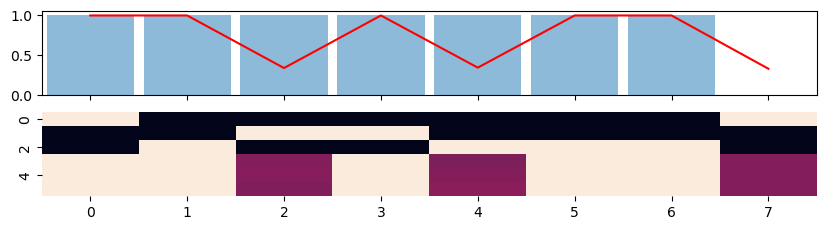

scaled_logprobs = tensor([-0.5493, -0.5493, -0.5488, -0.5488, -0.5488, -0.5483], device='cuda:1',
       dtype=torch.float16)
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	 < Nancy arrived at 9 o'clock. Deborah arrived at 4 o'clock. Dorothy arrived at 11 o'clock. >. Dorothy appeared the time just before 12 o'clock *▁:-0.001
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < William arrived in 2013. David arrived in 2014. Daniel arrived in 2015. >. William appeared the year just before 2014 *▁:-0.003
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < Sharon arrived at 5 o'clock. Betty arrived at 10 o'clock. Kenneth arrived at 4 o'clock. >. Sharon appeared the time just before 6 o'clock *▁:-0.002
 ▁aut 0.334 {'▁summer': 0.336, '▁aut': 0.334, '▁winter': 0.33, '<unk>': 0.0} 	  < Daniel arrived in spring. Donna arrived in summer. Michael arrived in autumn. >. Donna appeared the season just before autumn *▁aut:-0.010 ▁summer:-0.008 ▁winter:-0.024
 ▁Friday 0.

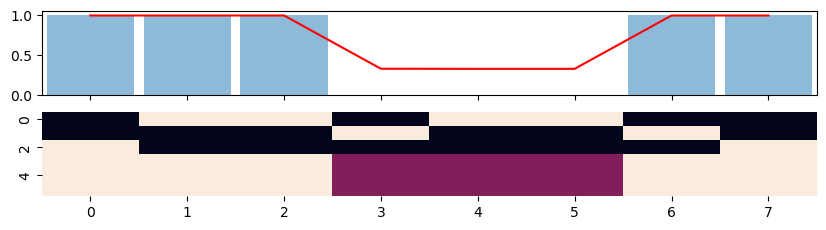

scaled_logprobs = tensor([-0.7324, -0.7300, -0.7280, -0.7261, -0.7246, -0.7241], device='cuda:1',
       dtype=torch.float16)
 ▁winter 0.332 {'▁summer': 0.338, '▁winter': 0.332, '▁aut': 0.33, '<unk>': 0.0} 	 < Jason arrived in spring. Kevin arrived in summer. Anthony arrived in autumn. >. Anthony showed up the season just before winter ▁aut:-0.015 ▁summer:0.008 *▁winter:-0.008
 ▁Saturday 0.333 {'▁Th': 0.334, '▁Saturday': 0.333, '▁T': 0.333, '<unk>': 0.0} 	  < Ronald arrived on Friday. Kimberly arrived on Monday. Joseph arrived on Wednesday. >. Ronald showed up the day just before Saturday ▁Th:-0.002 ▁T:-0.005 *▁Saturday:-0.005
 ▁December 0.317 {'▁July': 0.346, '▁September': 0.337, '▁December': 0.318, '<unk>': 0.0} 	  < Mark arrived in June. Steven arrived in November. Joseph arrived in August. >. Steven showed up the month just before December ▁July:0.058 *▁December:-0.028 ▁September:0.032
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < Laura arrived at 2 o'clock. Nancy a

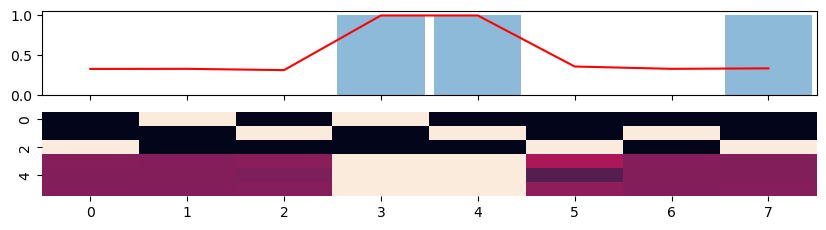

scaled_logprobs = tensor([-0.9155, -0.9121, -0.9082, -0.9048, -0.9023, -0.8989], device='cuda:1',
       dtype=torch.float16)
*▁Friday 0.334 {'▁Friday': 0.334, '▁Saturday': 0.334, '▁Wed': 0.333, '<unk>': 0.0} 	 < Elizabeth arrived on Tuesday. Richard arrived on Friday. Mark arrived on Thursday. >. Mark showed up the day just before Friday *▁Friday:0.004 ▁Wed:0.000 ▁Saturday:0.003
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < Thomas arrived at 8 o'clock. Mary arrived at 10 o'clock. Betty arrived at 5 o'clock. >. Betty showed up the time just before 6 o'clock *▁:-0.003
*▁Th 0.334 {'▁Th': 0.334, '▁Wed': 0.334, '▁T': 0.332, '<unk>': 0.0} 	  < Richard arrived on Tuesday. Christopher arrived on Monday. Karen arrived on Wednesday. >. Karen showed up the day just before Thursday *▁Th:0.001 ▁Wed:0.000 ▁T:-0.004
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < Donna arrived at 10 o'clock. Lisa arrived at 5 o'clock. Brian arrived at 2 o'clock. >. Donna showed up the t

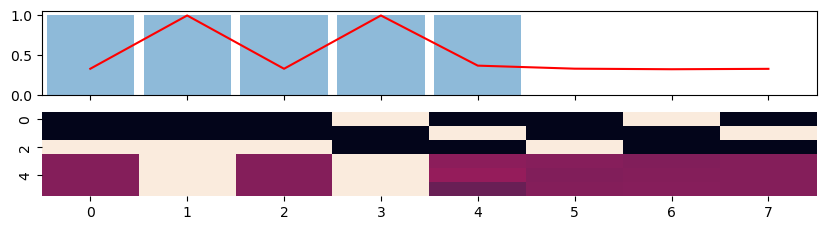

scaled_logprobs = tensor([-0.9155, -0.9023, -0.8892, -0.8770, -0.8657, -0.8550], device='cuda:1',
       dtype=torch.float16)
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	 < Kimberly arrived in 2010. Richard arrived in 2017. Elizabeth arrived in 2016. >. Kimberly arrived the year just before 2011 *▁:-0.002
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < Jennifer arrived at 3 o'clock. Sandra arrived at 10 o'clock. Richard arrived at 4 o'clock. >. Jennifer arrived the time just before 4 o'clock *▁:-0.003
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < John arrived in 2012. Mark arrived in 2013. Michael arrived in 2017. >. Mark arrived the year just before 2014 *▁:-0.003
 ▁winter 0.333 {'▁summer': 0.338, '▁winter': 0.332, '▁aut': 0.33, '<unk>': 0.0} 	  < Donald arrived in summer. Steven arrived in autumn. Mark arrived in spring. >. Steven arrived the season just before winter ▁aut:-0.035 ▁summer:-0.010 *▁winter:-0.026
 ▁summer 0.332 {'▁winter': 0.3

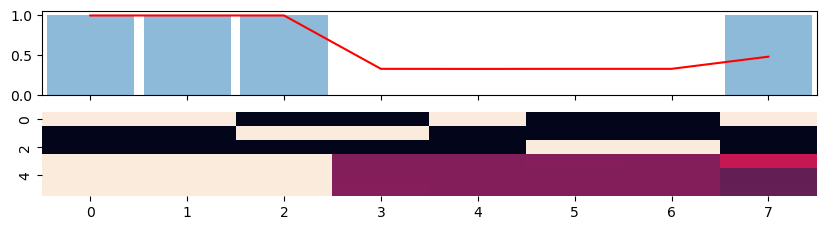

scaled_logprobs = tensor([-0.7324, -0.7305, -0.7285, -0.7266, -0.7251, -0.7231], device='cuda:1',
       dtype=torch.float16)
 ▁June 0.337 {'▁July': 0.348, '▁June': 0.338, '▁October': 0.315, '<unk>': 0.0} 	 < Margaret arrived in June. Sandra arrived in September. Sarah arrived in May. >. Sarah showed up the month just before June *▁June:-0.002 ▁July:0.027 ▁October:-0.071
 ▁T 0.332 {'▁Friday': 0.335, '▁Wed': 0.333, '▁T': 0.332, '<unk>': 0.0} 	  < Jason arrived on Monday. Susan arrived on Tuesday. Lisa arrived on Thursday. >. Jason showed up the day just before Tuesday ▁Friday:0.001 ▁Wed:-0.004 *▁T:-0.006
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < Elizabeth arrived in 2017. Patricia arrived in 2011. Jennifer arrived in 2016. >. Elizabeth showed up the year just before 2018 *▁:-0.002
*▁April 0.353 {'▁April': 0.353, '▁October': 0.325, '▁November': 0.322, '<unk>': 0.0} 	  < Nancy arrived in March. James arrived in October. Edward arrived in September. >. Nancy showed up t

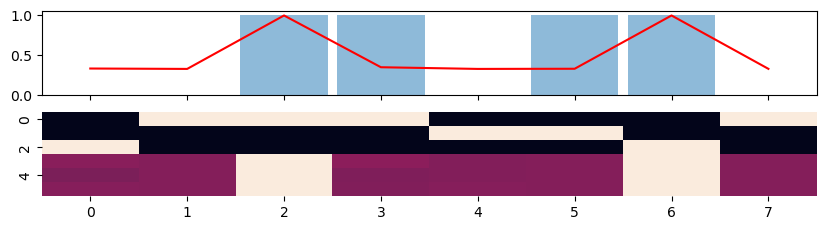

scaled_logprobs = tensor([-0.3662, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660], device='cuda:1',
       dtype=torch.float16)
*▁Friday 0.334 {'▁Friday': 0.334, '▁Saturday': 0.334, '▁Wed': 0.333, '<unk>': 0.0} 	 < Barbara arrived on Friday. Robert arrived on Thursday. John arrived on Tuesday. >. Robert appeared the day just before Friday *▁Friday:0.002 ▁Wed:-0.001 ▁Saturday:0.001
 ▁winter 0.329 {'▁summer': 0.341, '▁aut': 0.33, '▁winter': 0.329, '<unk>': 0.0} 	  < Edward arrived in autumn. Michelle arrived in spring. Ronald arrived in summer. >. Edward appeared the season just before winter ▁aut:-0.029 ▁summer:0.006 *▁winter:-0.031
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < Brian arrived at 2 o'clock. Michael arrived at 1 o'clock. Karen arrived at 6 o'clock. >. Michael appeared the time just before 2 o'clock *▁:-0.003
*▁ 1.0 {'▁': 1.0, '</s>': 0.0, '<unk>': 0.0, '<s>': 0.0} 	  < Donald arrived in 2011. Margaret arrived in 2015. Paul arrived in 2017. >. Donald appeared 

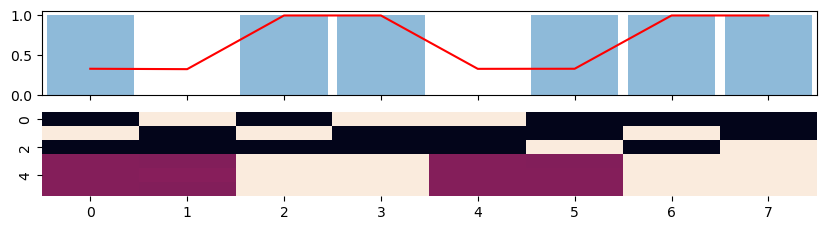

scaled_logprobs = tensor([-0.7324, -0.7271, -0.7227, -0.7173, -0.7129, -0.7085], device='cuda:1',
       dtype=torch.float16)
 ▁aut 0.331 {'▁summer': 0.338, '▁aut': 0.331, '▁winter': 0.331, '<unk>': 0.0} 	 < David arrived in spring. Helen arrived in summer. Lisa arrived in autumn. >. Helen appeared the season just before autumn *▁aut:-0.013 ▁summer:0.006 ▁winter:-0.015
*▁March 0.46 {'▁March': 0.46, '▁December': 0.308, '▁September': 0.232, '<unk>': 0.0} 	  < Robert arrived in February. Jeff arrived in November. Elizabeth arrived in August. >. Robert appeared the month just before March *▁March:0.370 ▁December:-0.031 ▁September:-0.317
*▁Th 0.334 {'▁Th': 0.334, '▁Wed': 0.333, '▁T': 0.333, '<unk>': 0.0} 	  < Donna arrived on Monday. Thomas arrived on Wednesday. Ronald arrived on Tuesday. >. Thomas appeared the day just before Thursday ▁Wed:-0.002 *▁Th:0.001 ▁T:-0.003
*▁Friday 0.334 {'▁Friday': 0.334, '▁Th': 0.333, '▁Saturday': 0.333, '<unk>': 0.0} 	  < Betty arrived on Wednesday. Deborah a

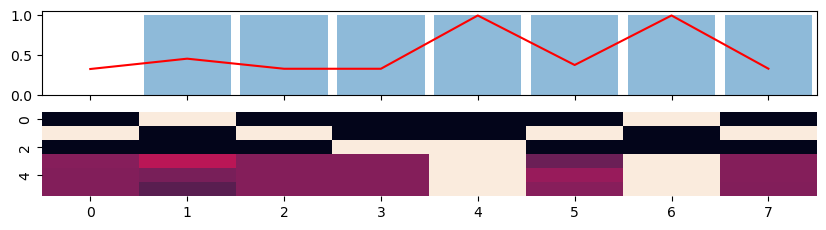

reduced_ap_scores = tensor([0.5518, 0.5415, 0.8057, 0.9336, 0.4146, 0.7744], device='cuda:1',
       dtype=torch.float16) tensor(0.6704, device='cuda:1', dtype=torch.float16)


In [41]:
plot_attn_attrs(r.data_tuples[:], model, tokenizer, node, topi=[3], attn_patterns=['A]->Q]'], is_relating_head=False, k_shot=k_shot+2, mix=True)

In [81]:
len(r.root.children[-1].children)

2

In [238]:
# import plotly.offline as pyo
# pyo.init_notebook_mode()

# from logits_dynamics import batch_logits_lens
# topk= model.transformer.wte.weight.data.shape[0]
# tgt = ['▁Yes', '▁No']
# fig1, fig2 = batch_logits_lens(r.data_tuples[0:1], model, tokenizer, heatmap=True,tgt=tgt, metric='target', case_sensitive=True, task_name='', topk=topk, verbose=False, orders=[1,2], scan_layer=[])
# fig1.show(), fig2.show()

In [29]:
#node是当前想查询节点的父节点，这里我们想查询'17-10,16-17,19-33 B->Q1'后面的@0 15-40 100 Q1->Q1 1/1/-1749,这个要定位到父节点，node.name=父节点
node = r.root.children[-1]; node.name
node.name
# node = r.root.children[-1].children[-1].children[-2]; node.name

'38-22,31-50,36-26 B->A^ attn'

In [17]:
print_tree(r.root)

 ┌@[3,4,5,7,9,10,11,12,13,14] 20-m,25-m,33-m,53-m,57-m,46-m,43-m,29-m 29,49-m 28,56-m 28 B->B 67
 ├@:3 36-26,38-22,31-50 B->A]^ 19
 ├@[6,8] 37-9,32-21 unk 0
 ├@3 20-m 75
 ├@4 25-m 50
 ├@5 33-m 47
 ├@7 53-m 38
 ├@9 57-m 34
 ├@10 46-m 32
 ├@11 43-m 31
 ├@12 29-m 29
 ├@13 49-m 28
 ├@14 56-m 28
 ├@0 36-26 100 B->A]^ 92/36 attn
 ├@1 38-22 95 B->A]^ 93/98 attn
 ├@2 31-50 77 B->A]^ 100/80 attn
 ├@6 37-9 43 B->B^ 90/52 attn
 ├@8 32-21 38 B->Q1 79/17/69 attn
 ├@8 32-21 38 B->Q1 79/17/69
 │                             ┌@[3,4,5,9,10,11,12] 27-m,25-m,28-m,29-m 26,24-m 25,31-m 22,23-m 21 B->B 48
 │                             ├@[0,1,2,6,7,13,14] 26-51,23-27,24-34,26-13 30,26-27 29,23-3 21,14-42 21 B->A]^ 42
 │                             ├@[8] 37-9 26 B->B^ 7
 │                             ├@3 27-m 38
 │                             ├@4 25-m 36
 │                             ├@5 28-m 31
 │                             ├@9 29-m 26
 │                             ├@10 24-m 25
 │                         

In [85]:
heads = np.array(topk_md(head_attr_fn(node.data.attr), 20)[:2])[:, 3] if layer is None else [wrap(layer), wrap(head)]

NameError: name 'get_head_mlp_att' is not defined

In [ ]:
all_examples, texts, all_bos_tokens = mathlogic_dataset
print('all_examples', all_examples, '\ntexts',texts,'\nall_bos_tokens',all_bos_tokens)

1.There are jersey<font color="#dd0000">(ans0)</font>,uniform<font color="#dd0000">(ans0)</font>,jeep.(sep) How many clothing(query) are there? Answer:(bos) Two(ans).\n   无tgt，ntgt，当 ans == len(cxt)时无 nans0

2.There are spaghetti<font color="blue">(ans1)</font>,hamburger<font color="blue">(ans1)</font>,burger<font color="blue">(ans1)</font>,soda<font color="#dd0000">(ans0)</font>,steak<font color="blue">(ans1)</font>.(sep) Are there more drink(query) than food(query)? Answer:(bos) No(ans).\n   无tgt

3.Lisa(tgt) has pizza<font color="#dd0000">(ans0)</font>, Anthony has spaghetti, Steven(tgt1) has spaghetti(ans1).(sep) Do Steven(query) and Lisa(query) have the same thing? Answer: (bos) No(ans).

4.A(tgt)'s name is Austin<font color="#dd0000">(ans0)</font>, S's name is Harrison, Q's name is Ashley, D's name is Katherine, W(tgt)'s name is Dylan(ans0). Is the gender of A(query) the same as W(query)? Answer:(bos) Yes(ans). 

5.V's name is Mark, D(tgt)'s name is Christopher<font color="#dd0000">(ans0)</font>, K's name is William, N's name is Deborah, X's name is Barbara. Is D(query) a boy? Answer:(bos) Yes(ans).

data_tuples中有用的数据text, input_ids, labels, ranges, *_, o = data_tuple

In [30]:
len(r.data_tuples)

2

In [19]:
a = [[0,1],[2,3]]
a = torch.tensor(a)
a.repeat(1,2)

tensor([[0, 1, 0, 1],
        [2, 3, 2, 3]])

In [629]:
def locate_example(ids, token):
    ids = ids == tokenizer.encode(token)[-1]
    Example = []
    for i in range(len(ids.nonzero())):
        if(i-1<0):
            example = (1,int(ids.nonzero()[i][0]))
        else:
            example = (int(ids.nonzero()[i-1][0]+1),int(ids.nonzero()[i][0]))
        Example.append(example)
    return Example

def locate(ids, token):
    if token == '.':
        ids_bool = ids == 29889
    else:
        ids_bool = ids == tokenizer.encode(token)[1]
    
    Example = []
    loc = ids_bool.nonzero()
#     print("token:",token,tokenizer.encode(token),"loc:",loc)
#     if(len(loc)<2):
    for i in range(len(loc)):
        if len(tokenizer.encode(token)[1:])>1 and ids[loc[i][0]+1] == tokenizer.encode(token)[2]:
            example = (int(loc[i][0]),int(loc[i][0])+len(tokenizer.encode(token)[1:]))
        elif len(tokenizer.encode(token)[1:]) <= 1:
            example = (int(loc[i][0]),int(loc[i][0])+len(tokenizer.encode(token)[1:]))
        else:
            continue
        Example.append(example)
    return Example

def find_thing(x,y,flag=False): #tuple类型
    Y = []
    Y.append(y[0])
    Y.append(y[1])
    if(flag == False):
        if x[0] not in Y: 
            return x[0],x[1]
        else: return None
    else:
        if x[0] in Y: 
            return x[0],x[1]
        else: return None


def locate_query_tgt(ids,tokens,example):

    Loc = [] #所有query和tgt的位置
    sorted_loc = []
    for i in range(len(tokens[2])):
        for q in tokens[2][i]:
            loc = locate(ids,q)
#             print("q:",q)
#             print("token:",q,"loc:",loc)
            Loc.extend(loc)  #所有tgt和query的位置
    
    for i in example:
        sort_loc = []
        for j in Loc:
            if i[0]<=j[1] and j[1]<=i[1]:
                sort_loc.append(j)
        sorted_loc.append(sort_loc)   #每个问题排序后的tgt,query位置,使用下面的内容排列
        
    
    tgt0 = [];query0=[];tgt1=[];query1=[]
    for i in sorted_loc:
        tgt0.append(i[0])
        query0.append(i[1])
        tgt1.append(i[2])
        query1.append(i[3])
        
    return tgt0,query0,tgt1,query1;

def tuple2list(tuplelist):
    if len(tuplelist)>1:
        for i in tuplelist:
            list_0.append(i[0])
            list_1.append(i[1])
    return (np.array(list_0),np.array(list_1))
    
    
def locate_other(ids,tokens,example):
    print(tokens[1])
    Nans0 = [];Ntgt = [];Ans0 = [];Tgt = []
    Nans0_loc = [];Ntgt_loc = [[] for _ in range(len(example))];Ans0_loc = [];Tgt_loc = []
    for i in range(len(tokens[2])):
        ntgt = [];nans0=[];tgt=[];ans0=[]
        for n in tokens[1][i]:
            if find_thing(n,tokens[2][i],False) is not None:
                ntgt.append(find_thing(n,tokens[2][i],False)[0])
                nans0.append(find_thing(n,tokens[2][i],False)[1])
            if find_thing(n,tokens[2][i],True) is not None:
                tgt.append(find_thing(n,tokens[2][i],True)[0])
                ans0.append(find_thing(n,tokens[2][i],True)[1])
        #得到tgt,ntgt,ans0和nans0的token
        Ntgt.append(ntgt)
        Nans0.append(nans0)
        Tgt.append(tgt)
        Ans0.append(ans0)
                
    print("Ntgt",Ntgt,"tgt",Tgt)
    for nt,na,t,a in zip(Ntgt,Nans0,Tgt,Ans0):
        for i,j in zip(nt,na):
            loc = locate(ids,i) 
            for d in loc: #判断当前loc是否在范围内
                for t,num in enumerate(example):
                    
                    if num[0]<=d[1] and d[1]<=num[1]:
                        Ntgt_loc[i].append(d) 
    print("Ntgt_loc",Ntgt_loc)

In [674]:
def make_data_list(text,input_strs,eval_dataset):
    data_tuples = []
    for i in range(len(input_strs)):
#         print("*********************************")
#         print("名词",input_strs[i][1:])
        label = eval_dataset[i]['labels'].tolist()
        label.append(-100)
        example = locate_example(eval_dataset[i]['input_ids'],"\n")
        bos = locate(eval_dataset[i]['input_ids'],"Answer:")
        ans = [(b[1]+1,b[1]+2) for b in bos]
        sep1 = locate(eval_dataset[i]['input_ids'],".")
        sep = [sep1[i] for i in range(0,len(sep1),2)]
        tgt0,query0,tgt1,query1 = locate_query_tgt(eval_dataset[i]['input_ids'],input_strs[i],example)

#         print("bos:",bos,"ans",ans,"query0",query0,"query1",query1,"tgt0",tgt0,"tgt1",tgt1,"sep",sep,"example",example)
        ranges = [Ranges(bos[i],ans[i],query0[i],query1[i],tgt0[i],tgt1[i],sep[i],example[i]) for i in range(len(bos))]
        data_tuples.append([text[i],eval_dataset[i]['input_ids'],torch.tensor(label)[1:],ranges])
    return data_tuples

eval_dataset = CHILDDataset(text, tokenizer)
print(make_data_list(text,input_strs,eval_dataset))

[['Ruth has pizza, Laura has pizza, Dorothy has steak. Do Ruth and Laura have the same thing? Answer: Yes.\n Karen has burger, Sandra has spaghetti, Kevin has burger. Do Karen and Kevin have the same thing? Answer: Yes.\n Nancy has steak, Steven has burger, Dorothy has steak. Do Steven and Nancy have the same thing? Answer: No.\n Ronald has pizza, Christopher has burger, Edward has steak. Do Edward and Ronald have the same thing? Answer: No.\n', tensor([    1, 23130,   756,   282, 24990, 29892, 21671,   756,   282, 24990,
        29892,  9579, 20336,   756,  1886,   557, 29889,  1938, 23130,   322,
        21671,   505,   278,  1021,  2655, 29973,   673, 29901,  3869, 29889,
           13,  3467,   264,   756,  6866,   914, 29892,  8564,   336,   756,
          805, 21705,  9890, 29892, 19323,   756,  6866,   914, 29889,  1938,
         3467,   264,   322, 19323,   505,   278,  1021,  2655, 29973,   673,
        29901,  3869, 29889,    13, 24190,   756,  1886,   557, 29892, 24703,
    

In [721]:
< Busan attracts Brian. Novosibirsk attracts Kenneth. Birmingham attracts Mary. >.
The boys do not want to visit Birmingham  2
< Madrid attracts Joseph. Vancouver attracts Daniel. Incheon attracts Maria. >. 
The boys do not want to visit Incheon   2
< Florence attracts Maria. Manchester attracts Michelle. Kyoto attracts Kenneth. >. 
The girls do not want to visit Kyoto   2
< Osaka attracts Mark. Rio de Janeiro attracts Karen. Moscow attracts Christopher. >. 
The boys do not want to visit Rio de Janeiro  1
< Florence attracts Paul. New York attracts Sandra. Vancouver attracts Kenneth. >. 
The boys do not want to visit New York   1
< Seoul attracts Patricia. Vancouver attracts Paul. Tokyo attracts Kevin. >. 
The boys do not want to visit Seoul   0

['▁Madrid', '▁V', '▁In']

In [86]:
# print(str(name))
print(input_strs)

['Michael has pizza, Donna has steak, Elizabeth has meat. Do Donna and Elizabeth have the same thing? Answer: No.\nKimberly has burger, Paul has pizza, Deborah has hamburger. Do Paul and Deborah have the same thing? Answer: No.\nBetty has spaghetti, Charles has meat, Kenneth has pizza. Do Charles and Kenneth have the same thing? Answer: No.\nBrian has meat, Richard has meat, Margaret has cake. Do Brian and Richard have the same thing? Answer: Yes.\n', 'Steven has bread, Richard has cake, Linda has cake. Do Steven and Richard have the same thing? Answer: No.\nMark has steak, Kevin has steak, Laura has burger. Do Kevin and Laura have the same thing? Answer: No.\nDorothy has meat, Sarah has spaghetti, Christopher has spaghetti. Do Sarah and Christopher have the same thing? Answer: Yes.\nLisa has pizza, Anthony has spaghetti, Steven has spaghetti. Do Steven and Lisa have the same thing? Answer: No.\n']


In [12]:
attribute_format = {'key':{'text':(),'bos':[],'input_ids':[]}}

In [8]:
bos_id = tokenizer.encode("Answer:")[-1] #->
eos_id = tokenizer.encode("\n")[-1]   #\n

class CHILDDataset(Dataset):
    def __init__(self, input_strs, tokenizer):

        self.inputs = tokenizer.batch_encode_plus(input_strs, padding=True, return_tensors='pt')
        input_ids = self.inputs.input_ids
        self.labels = torch.ones_like(input_ids) * (-100)
        for bi in range(input_ids.size(0)):
            bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
            eos_indices = (input_ids[bi] == eos_id).nonzero()[-len(bos_indices):].squeeze(1) #每一位 eos都比bos大2
            for i, (bos_i, eos_i) in enumerate(zip(bos_indices.tolist(), eos_indices.tolist())):
                assert eos_i > bos_i + 1
                self.labels[bi, eos_i-2] = input_ids[bi, eos_i-2] 
        
        
    def re_input(self):
        return self.inputs['input_ids']
        
    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, i):
        return {'input_ids': self.inputs['input_ids'][i],  #输入
                'attention_mask': self.inputs['attention_mask'][i],
                'labels': self.labels[i]}   #结果

In [103]:

# # num+=1
# with open(f'data/data_1_{num}.json') as f:
#     input_strs = json.load(f)
# print("num:",num)
# print(input_strs[-1])


In [11]:
eval_dataset[0]

{'input_ids': tensor([    1,   399, 29915, 29879,  1024,   338,  4755, 29892,  1060, 29915,
         29879,  1024,   338, 21776, 29892,   379, 29915, 29879,  1024,   338,
         25914, 29892,   319, 29915, 29879,  1024,   338,  6217, 29892,   317,
         29915, 29879,  1024,   338, 18935, 29889,  1317,   379,   263,  8023,
         29973,   673, 29901,  1939, 29889,    13, 29911, 29915, 29879,  1024,
           338,  6182, 29892,   350, 29915, 29879,  1024,   338, 21671, 29892,
           660, 29915, 29879,  1024,   338, 18935, 29892,   349, 29915, 29879,
          1024,   338,  5765, 29892,   405, 29915, 29879,  1024,   338,  9579,
         20336, 29889,  1317,   349,   263,  7826, 29973,   673, 29901,  1939,
         29889,    13, 29950, 29915, 29879,  1024,   338, 12208, 29892,   660,
         29915, 29879,  1024,   338,  3739, 29892,   317, 29915, 29879,  1024,
           338, 21776, 29892,   501, 29915, 29879,  1024,   338,  6123, 29892,
           382, 29915, 29879,  1024,   

## 测试部分

In [141]:
def make_table(data,length):
    # 创建DataFrame
    df = pd.DataFrame(data,index = [i for i in range(length)])
    return df

def split_shot(label_mask):  #返回每个label_mask的非-100位置 tensor
    LOC = []
    for ids in label_mask:
        LOC.append((ids == True).nonzero()[0].tolist())
    return torch.tensor(LOC)

def count_acc(LOC,pred_ids,labels_ids,ANS_id):
    predict_ids = pred_ids.argmax(-1) 
    sum_acc = torch.zeros(len(LOC[0]))  #每个位置的正确个数
    for i in range(len(LOC)):
        for j in range(len(LOC[0])): 
            ansloc_prob = pred_ids[i][LOC[i][j]]   #答案位置所有词的概率
            ans = labels_ids[i][LOC[i][j]]         #答案id
            
            if(ans in ANS_id):
                sum_acc[j] += 1 if ansloc_prob[ans] > ansloc_prob[ANS_id[abs(ANS_id.index(ans)-1)]] else 0
                                  #答案概率                 #另一个答案的概率
            else:
                sum_acc[j] += 1 if predict_ids[i][LOC[i][j]] == ans else 0
                
    for i in range(len(sum_acc)):
        sum_acc[i] = np.around((sum_acc[i] / len(LOC)),4)
    return sum_acc

# def compute_metrics(eval_preds):
#     pred_ids = eval_preds.predictions[:, :-1]
#     labels_ids = eval_preds.label_ids[:, 1:]    #偏移
    
#     # 保持维度一致。
#     assert labels_ids.shape == pred_ids.shape, f'{labels_ids.shape} != {pred_ids.shape}'
#     # 将label是-100的地方mask掉，不计算准确率。
#     label_mask = (labels_ids != -100)    #tensor([False, False,  True, False, False,  True])
#     LOC = split_shot(label_mask)

#     # 计算总的准确率。
#     accuracy = ((pred_ids == labels_ids ) * label_mask).sum(-1) / label_mask.sum(-1)   #这里将每个位置的准确率求平均了
#     shot_acc = count_acc(LOC,pred_ids,labels_ids)
#     return { f'ACC_{i}': shot_acc[i] for i in range(len(shot_acc))}
    
def preprocess_logits_for_metrics(logits, labels):   #logits转换为各位置概率最高的值
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1) 

In [144]:
ANS = ['▁Yes','▁No','▁Zero','▁One','▁Two','▁Three','▁<','▁>','▁=','▁yes','▁no']
ANS_id = []

for i in ANS:
    ANS_id.append(tokenizer.encode(i)[-1])
    
excel = {
        'ans': [],
        'predict': [],
}

def compute_metrics(eval_preds):
    pred_ids = eval_preds.predictions[:, :-1]    #每个位置logits
    labels_ids = eval_preds.label_ids[:, 1:]    #每个句子的label
#     print("pred_ids:",len(pred_ids[0]))   #logits
    label_mask = (labels_ids != -100) 
    LOC = split_shot(label_mask)                #LOC: labels_ids非-100的位置
    
#     accuracy = ((predict_ids == labels_ids ) * label_mask).sum(-1) / label_mask.sum(-1)   #这里将每个位置的准确率求平均了
    shot_acc = count_acc(LOC,pred_ids,labels_ids, ANS_id[:2])
    
    labels = []
    preds = []
    Softmax = nn.Softmax(dim = -1)
    
    for sentence in range(len(LOC)):       
        ids = torch.from_numpy(pred_ids[sentence]).float()  #size:(句子长，词表长)
        prob = Softmax(ids)   #label位置的所有词的概率
        for ans_loc in LOC[sentence]:
            label = labels_ids[sentence][ans_loc] #当前位置正确答案
            
            ansloc_prob = prob[ans_loc]  #答案位置所有词的概率 
            highest_token_id =  ansloc_prob.argmax(-1)   #答案位置概率最高的词的id（位置）
            
            data = []
            data_dict = {}
            
            for ans in range(len(ANS_id)):
                if(ansloc_prob[ANS_id[ans]].item()>0.01):
                    data_dict[ANS[ans]]=np.around(ansloc_prob[ANS_id[ans]].item(), decimals=2)
            
            data_dict=sorted(data_dict.items(),key = lambda x:x[1],reverse = True)  
            for i,j in data_dict:
                data.append(i+":"+str(j))

            if(len(data_dict)>0 and tokenizer.convert_ids_to_tokens(label.item()) == data_dict[0][0]):
                excel['ans'].append("*"+tokenizer.convert_ids_to_tokens(label.item()))  #构造表格(ans)
            else:    
                excel['ans'].append(tokenizer.convert_ids_to_tokens(label.item()))  #构造表格(ans)
            excel['predict'].append(data)  #构造表格(predict)
    Excel = make_table(excel,len(excel['ans']))
    print(Excel)
    
    return { f'ACC_{i}': shot_acc[i] for i in range(len(shot_acc))}

In [145]:
training_args = TrainingArguments(
    output_dir="/home/nrk/vicuna-33b",                                                           
    overwrite_output_dir=True, 
    do_train=False, 
    do_eval=True, 
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=1,                                                  
    save_steps=100,
    save_strategy='no',                                                                                       
)

In [146]:
trainer = Trainer(model=model,
                  args=training_args,  
                  eval_dataset=eval_dataset,
                  compute_metrics=compute_metrics,
                 )

In [138]:
trainer.evaluate()

{'eval_loss': 0.373291015625,
 'eval_ACC_0': 0.777999997138977,
 'eval_ACC_1': 0.8180000185966492,
 'eval_ACC_2': 0.9039999842643738,
 'eval_ACC_3': 0.8460000157356262,
 'eval_ACC_4': 0.8659999966621399,
 'eval_ACC_5': 0.8679999709129333,
 'eval_ACC_6': 0.8659999966621399,
 'eval_ACC_7': 0.8840000033378601,
 'eval_ACC_8': 0.8880000114440918,
 'eval_runtime': 142.2362,
 'eval_samples_per_second': 3.515,
 'eval_steps_per_second': 1.758}

In [129]:
trainer.evaluate()   #原问法 , context = 5

      ans                predict
0     ▁No  [▁Yes:0.38, ▁No:0.36]
1    ▁Yes  [▁No:0.56, ▁Yes:0.44]
2    ▁Yes  [▁No:0.59, ▁Yes:0.41]
3     ▁No  [▁Yes:0.72, ▁No:0.28]
4     ▁No    [▁Yes:0.7, ▁No:0.3]
5     ▁No  [▁Yes:0.71, ▁No:0.29]
6   *▁Yes  [▁Yes:0.65, ▁No:0.35]
7    ▁Yes  [▁No:0.56, ▁Yes:0.44]
8     ▁No  [▁Yes:0.63, ▁No:0.37]
9   *▁Yes  [▁Yes:0.44, ▁No:0.41]
10  *▁Yes  [▁Yes:0.59, ▁No:0.41]
11    ▁No  [▁Yes:0.92, ▁No:0.08]
12  *▁Yes  [▁Yes:0.71, ▁No:0.29]
13  *▁Yes  [▁Yes:0.52, ▁No:0.48]
14    ▁No  [▁Yes:0.79, ▁No:0.21]
15    ▁No  [▁Yes:0.85, ▁No:0.15]
16  *▁Yes  [▁Yes:0.64, ▁No:0.36]
17    ▁No  [▁Yes:0.71, ▁No:0.29]
18   ▁Yes  [▁No:0.42, ▁Yes:0.33]
19   ▁Yes  [▁No:0.52, ▁Yes:0.48]
20    ▁No  [▁Yes:0.83, ▁No:0.17]
21  *▁Yes    [▁Yes:0.8, ▁No:0.2]
22    ▁No  [▁Yes:0.67, ▁No:0.33]
23  *▁Yes    [▁Yes:0.5, ▁No:0.5]
24  *▁Yes  [▁Yes:0.79, ▁No:0.21]
25    ▁No  [▁Yes:0.79, ▁No:0.21]
26    ▁No  [▁Yes:0.89, ▁No:0.11]
27    ▁No  [▁Yes:0.53, ▁No:0.29]
28  *▁Yes  [▁Yes:0.53, ▁No:0.47]
29  *▁Yes 

{'eval_loss': 0.96484375,
 'eval_ACC_0': 0.5,
 'eval_ACC_1': 0.6000000238418579,
 'eval_ACC_2': 0.30000001192092896,
 'eval_ACC_3': 0.6000000238418579,
 'eval_ACC_4': 0.4000000059604645,
 'eval_ACC_5': 0.10000000149011612,
 'eval_ACC_6': 0.4000000059604645,
 'eval_ACC_7': 0.5,
 'eval_ACC_8': 0.4000000059604645,
 'eval_runtime': 4.4124,
 'eval_samples_per_second': 2.266,
 'eval_steps_per_second': 1.133}

In [41]:
pd.set_option('display.max_rows', None)  # 设置显示最大

In [147]:
trainer.evaluate() #新问法 ，context = 5

      ans                predict
0    ▁Yes  [▁No:0.51, ▁Yes:0.31]
1    *▁No  [▁No:0.98, ▁Yes:0.01]
2     ▁No  [▁Yes:0.76, ▁No:0.24]
3   *▁Yes  [▁Yes:0.98, ▁No:0.01]
4    ▁Yes  [▁No:0.75, ▁Yes:0.25]
5   *▁Yes  [▁Yes:0.96, ▁No:0.04]
6    *▁No             [▁No:0.99]
7    *▁No  [▁No:0.89, ▁Yes:0.11]
8   *▁Yes  [▁Yes:0.66, ▁No:0.34]
9    ▁Yes  [▁No:0.47, ▁Yes:0.26]
10   *▁No  [▁No:0.67, ▁Yes:0.31]
11   *▁No  [▁No:0.91, ▁Yes:0.09]
12   ▁Yes  [▁No:0.69, ▁Yes:0.31]
13  *▁Yes  [▁Yes:0.71, ▁No:0.28]
14   *▁No  [▁No:0.72, ▁Yes:0.28]
15   ▁Yes  [▁No:0.67, ▁Yes:0.33]
16   ▁Yes  [▁No:0.98, ▁Yes:0.02]
17   *▁No  [▁No:0.91, ▁Yes:0.08]
18  *▁Yes  [▁Yes:0.52, ▁No:0.35]
19  *▁Yes  [▁Yes:0.74, ▁No:0.25]
20   *▁No  [▁No:0.93, ▁Yes:0.07]
21   *▁No  [▁No:0.54, ▁Yes:0.46]
22  *▁Yes  [▁Yes:0.95, ▁No:0.05]
23  *▁Yes  [▁Yes:0.68, ▁No:0.32]
24   *▁No  [▁No:0.98, ▁Yes:0.02]
25    ▁No  [▁Yes:0.54, ▁No:0.46]
26  *▁Yes  [▁Yes:0.88, ▁No:0.12]
27   *▁No  [▁No:0.64, ▁Yes:0.12]
28   ▁Yes  [▁No:0.53, ▁Yes:0.47]
29   *▁No 

{'eval_loss': 0.483642578125,
 'eval_ACC_0': 0.699999988079071,
 'eval_ACC_1': 0.5,
 'eval_ACC_2': 0.699999988079071,
 'eval_ACC_3': 0.800000011920929,
 'eval_ACC_4': 0.699999988079071,
 'eval_ACC_5': 1.0,
 'eval_ACC_6': 0.8999999761581421,
 'eval_ACC_7': 0.699999988079071,
 'eval_ACC_8': 0.800000011920929,
 'eval_runtime': 4.2553,
 'eval_samples_per_second': 2.35,
 'eval_steps_per_second': 1.175}

In [69]:
# with open(f"data/data_1_{num}.json", "a", encoding="utf-8") as f:
#     json.dump(result:=trainer.evaluate(), f) 
# result